In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.6


exoplanet version: 0.1.4


# Radial velocity fitting

In this tutorial, we will demonstrate how to fit radial velocity observations of an exoplanetary system using *exoplanet*.
We will follow [the getting started tutorial](https://radvel.readthedocs.io/en/latest/tutorials/K2-24_Fitting+MCMC.html) from [the exellent RadVel package](https://radvel.readthedocs.io) where they fit for the parameters of the two planets in [the K2-24 system](https://arxiv.org/abs/1511.04497).

First, let's download the data from RadVel:

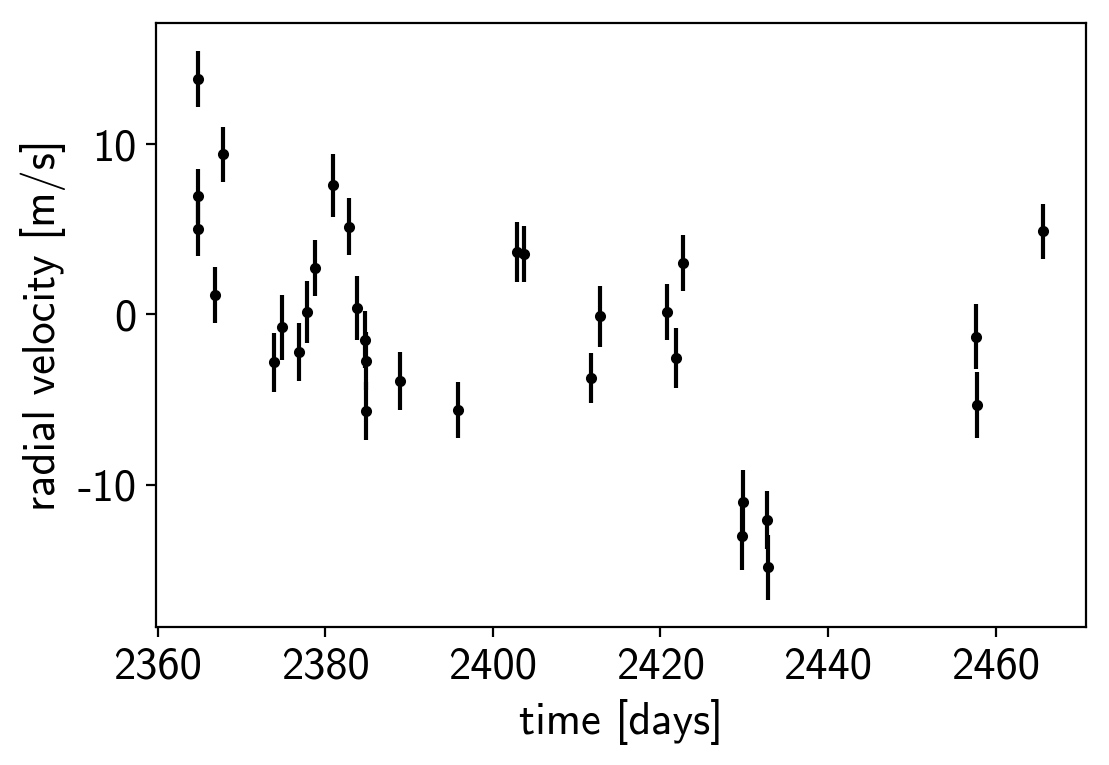

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

x = np.array(data.t)
y = np.array(data.vel)
yerr = np.array(data.errvel)

plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]");

Now, we know the periods and transit times for the planets [from the K2 light curve](https://arxiv.org/abs/1511.04497), so let's start by using the :func:`exoplanet.estimate_semi_amplitude` function to estimate the expected RV semi-amplitudes for the planets.

In [4]:
import exoplanet as xo

periods = [20.8851, 42.3633]
period_errs = [0.0003, 0.0006]
t0s = [2072.7948, 2082.6251]
t0_errs = [0.0007, 0.0004]
Ks = xo.estimate_semi_amplitude(periods, x, y, yerr, t0s=t0s)
print(Ks, "m/s")

[5.05069163 5.50983542] m/s


## The radial velocity model in PyMC3

Now that we have the data and an estimate of the initial values for the parameters, let's start defining the probabilistic model in PyMC3 (take a look at :ref:`intro-to-pymc3` if you're new to PyMC3).
First, we'll define our priors on the parameters:

In [5]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
        
    # Gaussian priors based on transit data (from Petigura et al.)
    t0 = pm.Normal("t0", mu=np.array(t0s), sd=np.array(t0_errs), shape=2)
    P = pm.Normal("P", mu=np.array(periods), sd=np.array(period_errs), shape=2)

    # Wide log-normal prior for semi-amplitude
    logK = pm.Normal("logK", mu=np.log(Ks), sd=10.0, shape=2)
    
    # This is a sanity check that restricts the semiamplitude to reasonable
    # values because things can get ugly as K -> 0
    pm.Potential("logK_bound", tt.switch(logK < 0, -np.inf, 0.0))
    
    # We also want to keep period physical but this probably won't be hit
    pm.Potential("P_bound", tt.switch(P <= 0, -np.inf, 0.0))

    # Eccentricity & argument of periasteron
    ecc = pm.Uniform("ecc", lower=0, upper=0.99, shape=2,
                     testval=np.array([0.1, 0.1]))
    omega = xo.distributions.Angle("omega", shape=2, testval=np.zeros(2))
    
    # Jitter & a quadratic RV trend
    logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sd=5.0)
    trend = pm.Normal("trend", mu=0, sd=10.0**-np.arange(3)[::-1], shape=3)

Now we'll define the orbit model:

In [6]:
with model:
    
    # Set up the orbit
    orbit = xo.orbits.KeplerianOrbit(
        period=P, t0=t0,
        ecc=ecc, omega=omega)
    
    # Set up the RV model and save it as a deterministic
    # for plotting purposes later
    vrad = orbit.get_radial_velocity(x, K=tt.exp(logK))
    pm.Deterministic("vrad", vrad)
    
    # Define the background model
    A = np.vander(x - 0.5*(x.min() + x.max()), 3)
    bkg = pm.Deterministic("bkg", tt.dot(A, trend))
    
    # Sum over planets and add the background to get the full model
    rv_model = pm.Deterministic("rv_model", tt.sum(vrad, axis=-1) + bkg)

For plotting purposes, it can be useful to also save the model on a fine grid in time.

In [7]:
t = np.linspace(x.min()-5, x.max()+5, 1000)

with model:
    vrad_pred = orbit.get_radial_velocity(t, K=tt.exp(logK))
    pm.Deterministic("vrad_pred", vrad_pred)
    A_pred = np.vander(t - 0.5*(x.min() + x.max()), 3)
    bkg_pred = pm.Deterministic("bkg_pred", tt.dot(A_pred, trend))
    rv_model_pred = pm.Deterministic("rv_model_pred",
                                     tt.sum(vrad_pred, axis=-1) + bkg_pred)

Now, we can plot the initial model:

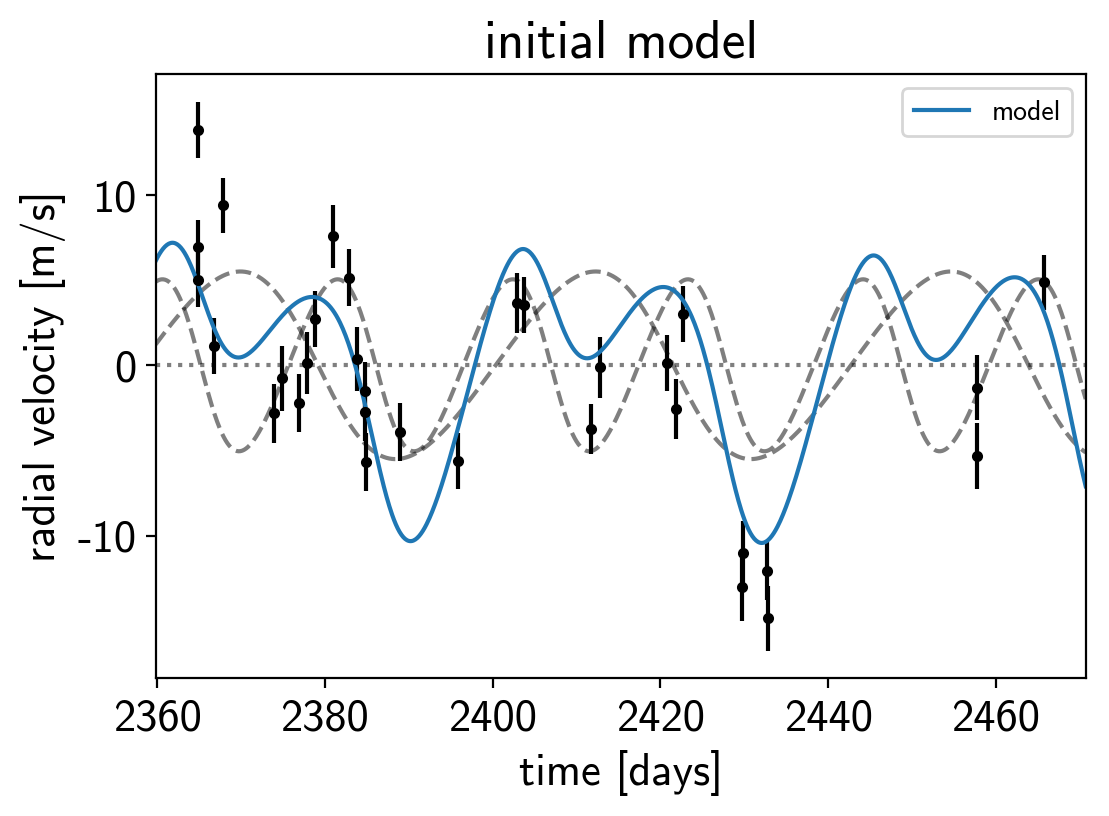

In [8]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

with model:
    plt.plot(t, xo.eval_in_model(vrad_pred), "--k", alpha=0.5)
    plt.plot(t, xo.eval_in_model(bkg_pred), ":k", alpha=0.5)
    plt.plot(t, xo.eval_in_model(rv_model_pred), label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("initial model");

In this plot, the background is the dotted line, the individual planets are the dashed lines, and the full model is the blue line.

It doesn't look amazing so let's add in the likelihood and fit for the maximum a posterior parameters.

In [9]:
with model:
    
    err = tt.sqrt(yerr**2 + tt.exp(2*logs))
    pm.Normal("obs", mu=rv_model, sd=err, observed=y)
    
    map_soln = xo.optimize(start=model.test_point, vars=[trend])
    map_soln = xo.optimize(start=map_soln)

success: True
initial logp: -90.11668240930777
final logp: -78.84603926211089


success: False
initial logp: -78.84603926211089
final logp: -61.97082948339889


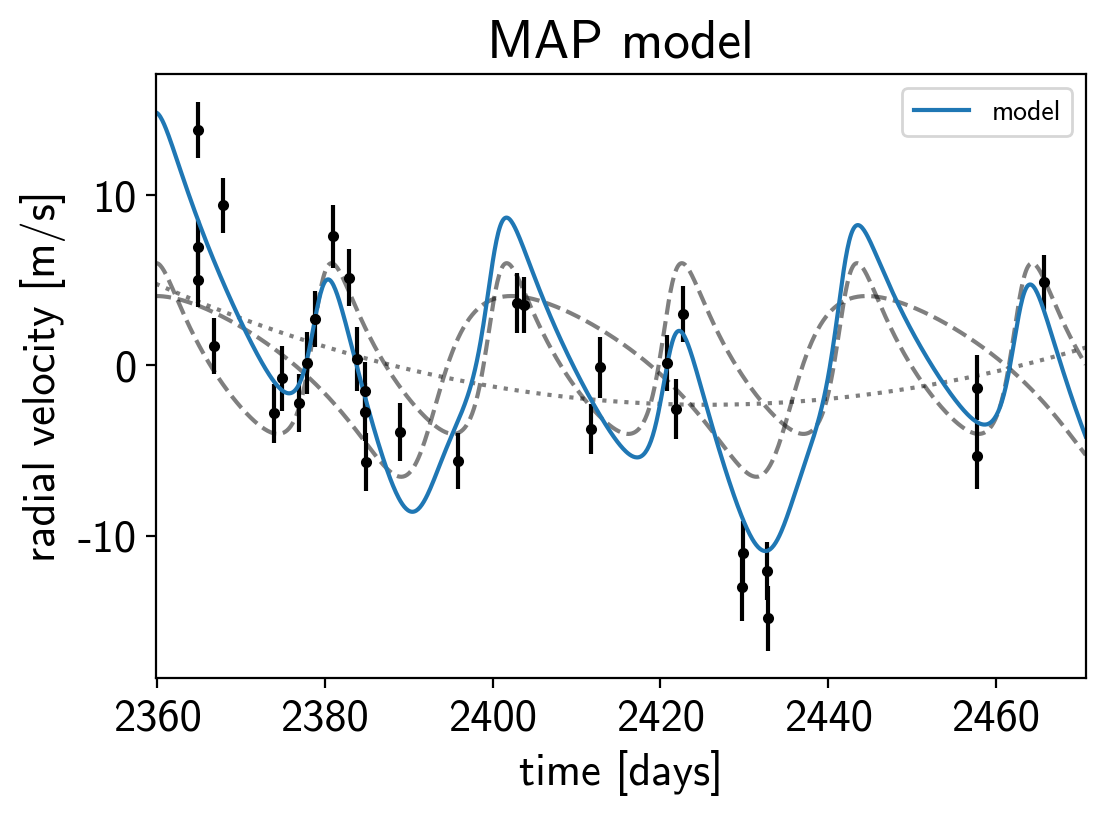

In [10]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.plot(t, map_soln["vrad_pred"], "--k", alpha=0.5)
plt.plot(t, map_soln["bkg_pred"], ":k", alpha=0.5)
plt.plot(t, map_soln["rv_model_pred"], label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("MAP model");

That looks better.

## Sampling

Now that we have our model set up and a good estimate of the initial parameters, let's start sampling.
There are substantial covariances between some of the parameters so we'll use a :class:`exoplanet.PyMC3Sampler` to tune the sampler (see the :ref:`pymc3-extras` tutorial for more information).

In [11]:
np.random.seed(42)
sampler = xo.PyMC3Sampler(start=200, window=100, finish=300)
with model:
    burnin = sampler.tune(tune=3000, start=model.test_point,
                          step_kwargs=dict(target_accept=0.9))
    trace = sampler.sample(draws=3000)

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 21/808 [00:00<00:05, 152.59draws/s]

Sampling 4 chains:   4%|▎         | 29/808 [00:00<00:06, 115.60draws/s]

Sampling 4 chains:   5%|▍         | 37/808 [00:00<00:07, 100.80draws/s]

Sampling 4 chains:   6%|▌         | 45/808 [00:00<00:08, 92.52draws/s] 

Sampling 4 chains:   7%|▋         | 53/808 [00:00<00:08, 87.56draws/s]

Sampling 4 chains:   8%|▊         | 61/808 [00:00<00:08, 84.43draws/s]

Sampling 4 chains:   9%|▊         | 69/808 [00:00<00:08, 82.43draws/s]

Sampling 4 chains:  10%|▉         | 77/808 [00:00<00:09, 81.12draws/s]

Sampling 4 chains:  11%|█         | 85/808 [00:00<00:09, 80.27draws/s]

Sampling 4 chains:  12%|█▏        | 93/808 [00:01<00:09, 78.85draws/s]

Sampling 4 chains:  12%|█▎        | 101/808 [00:01<00:08, 78.66draws/s]

Sampling 4 chains:  13%|█▎        | 109/808 [00:01<00:08, 78.46draws/s]

Sampling 4 chains:  14%|█▍        | 117/808 [00:01<00:08, 78.40draws/s]

Sampling 4 chains:  15%|█▌        | 125/808 [00:01<00:08, 78.28draws/s]

Sampling 4 chains:  16%|█▋        | 133/808 [00:01<00:08, 77.98draws/s]

Sampling 4 chains:  17%|█▋        | 141/808 [00:01<00:08, 78.03draws/s]

Sampling 4 chains:  18%|█▊        | 149/808 [00:01<00:08, 77.63draws/s]

Sampling 4 chains:  19%|█▉        | 157/808 [00:01<00:08, 75.58draws/s]

Sampling 4 chains:  20%|██        | 165/808 [00:02<00:08, 75.79draws/s]

Sampling 4 chains:  21%|██▏       | 173/808 [00:02<00:08, 75.98draws/s]

Sampling 4 chains:  22%|██▏       | 181/808 [00:02<00:08, 76.01draws/s]

Sampling 4 chains:  23%|██▎       | 189/808 [00:02<00:08, 76.16draws/s]

Sampling 4 chains:  25%|██▍       | 198/808 [00:02<00:07, 78.64draws/s]

Sampling 4 chains:  25%|██▌       | 206/808 [00:02<00:07, 78.11draws/s]

Sampling 4 chains:  26%|██▋       | 214/808 [00:02<00:07, 77.70draws/s]

Sampling 4 chains:  27%|██▋       | 222/808 [00:02<00:07, 76.08draws/s]

Sampling 4 chains:  28%|██▊       | 230/808 [00:02<00:07, 76.35draws/s]

Sampling 4 chains:  29%|██▉       | 238/808 [00:02<00:07, 76.54draws/s]

Sampling 4 chains:  30%|███       | 246/808 [00:03<00:07, 76.65draws/s]

Sampling 4 chains:  31%|███▏      | 254/808 [00:03<00:07, 76.74draws/s]

Sampling 4 chains:  32%|███▏      | 262/808 [00:03<00:07, 76.62draws/s]

Sampling 4 chains:  33%|███▎      | 270/808 [00:03<00:07, 76.70draws/s]

Sampling 4 chains:  34%|███▍      | 278/808 [00:03<00:06, 77.14draws/s]

Sampling 4 chains:  35%|███▌      | 286/808 [00:03<00:06, 76.70draws/s]

Sampling 4 chains:  36%|███▋      | 294/808 [00:03<00:06, 76.91draws/s]

Sampling 4 chains:  37%|███▋      | 302/808 [00:03<00:06, 76.79draws/s]

Sampling 4 chains:  38%|███▊      | 310/808 [00:03<00:06, 77.22draws/s]

Sampling 4 chains:  39%|███▉      | 318/808 [00:03<00:06, 77.21draws/s]

Sampling 4 chains:  40%|████      | 326/808 [00:04<00:06, 77.50draws/s]

Sampling 4 chains:  41%|████▏     | 334/808 [00:04<00:06, 76.80draws/s]

Sampling 4 chains:  42%|████▏     | 342/808 [00:04<00:06, 76.76draws/s]

Sampling 4 chains:  43%|████▎     | 350/808 [00:04<00:05, 76.84draws/s]

Sampling 4 chains:  44%|████▍     | 358/808 [00:04<00:05, 76.88draws/s]

Sampling 4 chains:  45%|████▌     | 367/808 [00:04<00:05, 79.21draws/s]

Sampling 4 chains:  46%|████▋     | 375/808 [00:04<00:05, 78.53draws/s]

Sampling 4 chains:  47%|████▋     | 383/808 [00:04<00:05, 78.02draws/s]

Sampling 4 chains:  48%|████▊     | 391/808 [00:04<00:05, 77.73draws/s]

Sampling 4 chains:  49%|████▉     | 399/808 [00:05<00:05, 77.49draws/s]

Sampling 4 chains:  50%|█████     | 407/808 [00:05<00:05, 77.33draws/s]

Sampling 4 chains:  51%|█████▏    | 415/808 [00:05<00:05, 77.22draws/s]

Sampling 4 chains:  52%|█████▏    | 423/808 [00:05<00:04, 77.65draws/s]

Sampling 4 chains:  53%|█████▎    | 432/808 [00:05<00:04, 80.55draws/s]

Sampling 4 chains:  55%|█████▍    | 441/808 [00:05<00:04, 79.81draws/s]

Sampling 4 chains:  56%|█████▌    | 450/808 [00:05<00:04, 79.83draws/s]

Sampling 4 chains:  57%|█████▋    | 458/808 [00:05<00:04, 78.88draws/s]

Sampling 4 chains:  58%|█████▊    | 466/808 [00:05<00:04, 78.15draws/s]

Sampling 4 chains:  59%|█████▊    | 474/808 [00:05<00:04, 77.77draws/s]

Sampling 4 chains:  60%|█████▉    | 482/808 [00:06<00:04, 77.50draws/s]

Sampling 4 chains:  61%|██████    | 490/808 [00:06<00:04, 77.48draws/s]

Sampling 4 chains:  62%|██████▏   | 498/808 [00:06<00:03, 77.74draws/s]

Sampling 4 chains:  63%|██████▎   | 506/808 [00:06<00:03, 77.99draws/s]

Sampling 4 chains:  64%|██████▎   | 514/808 [00:06<00:03, 78.21draws/s]

Sampling 4 chains:  65%|██████▍   | 522/808 [00:06<00:03, 78.32draws/s]

Sampling 4 chains:  66%|██████▌   | 530/808 [00:06<00:03, 78.08draws/s]

Sampling 4 chains:  67%|██████▋   | 538/808 [00:06<00:03, 78.04draws/s]

Sampling 4 chains:  68%|██████▊   | 546/808 [00:06<00:03, 78.48draws/s]

Sampling 4 chains:  69%|██████▊   | 554/808 [00:07<00:03, 78.49draws/s]

Sampling 4 chains:  70%|██████▉   | 562/808 [00:07<00:03, 78.52draws/s]

Sampling 4 chains:  71%|███████   | 570/808 [00:07<00:03, 78.48draws/s]

Sampling 4 chains:  72%|███████▏  | 578/808 [00:07<00:02, 78.53draws/s]

Sampling 4 chains:  73%|███████▎  | 586/808 [00:07<00:02, 78.54draws/s]

Sampling 4 chains:  74%|███████▎  | 594/808 [00:07<00:02, 78.54draws/s]

Sampling 4 chains:  75%|███████▍  | 602/808 [00:07<00:02, 78.66draws/s]

Sampling 4 chains:  75%|███████▌  | 610/808 [00:07<00:02, 78.33draws/s]

Sampling 4 chains:  76%|███████▋  | 618/808 [00:07<00:02, 78.38draws/s]

Sampling 4 chains:  77%|███████▋  | 626/808 [00:07<00:02, 78.00draws/s]

Sampling 4 chains:  78%|███████▊  | 634/808 [00:08<00:02, 76.90draws/s]

Sampling 4 chains:  79%|███████▉  | 642/808 [00:08<00:02, 76.58draws/s]

Sampling 4 chains:  80%|████████  | 650/808 [00:08<00:02, 76.74draws/s]

Sampling 4 chains:  81%|████████▏ | 658/808 [00:08<00:01, 76.87draws/s]

Sampling 4 chains:  82%|████████▏ | 666/808 [00:08<00:01, 77.07draws/s]

Sampling 4 chains:  83%|████████▎ | 674/808 [00:08<00:01, 77.70draws/s]

Sampling 4 chains:  84%|████████▍ | 682/808 [00:08<00:01, 78.09draws/s]

Sampling 4 chains:  85%|████████▌ | 690/808 [00:08<00:01, 78.02draws/s]

Sampling 4 chains:  86%|████████▋ | 698/808 [00:08<00:01, 78.09draws/s]

Sampling 4 chains:  87%|████████▋ | 706/808 [00:08<00:01, 77.72draws/s]

Sampling 4 chains:  88%|████████▊ | 714/808 [00:09<00:01, 77.37draws/s]

Sampling 4 chains:  89%|████████▉ | 722/808 [00:09<00:01, 77.24draws/s]

Sampling 4 chains:  90%|█████████ | 730/808 [00:09<00:01, 77.17draws/s]

Sampling 4 chains:  91%|█████████▏| 738/808 [00:09<00:00, 76.93draws/s]

Sampling 4 chains:  92%|█████████▏| 746/808 [00:09<00:00, 76.86draws/s]

Sampling 4 chains:  93%|█████████▎| 754/808 [00:09<00:00, 76.85draws/s]

Sampling 4 chains:  94%|█████████▍| 762/808 [00:09<00:00, 76.91draws/s]

Sampling 4 chains:  95%|█████████▌| 770/808 [00:09<00:00, 77.01draws/s]

Sampling 4 chains:  96%|█████████▋| 778/808 [00:09<00:00, 77.11draws/s]

Sampling 4 chains:  97%|█████████▋| 786/808 [00:10<00:00, 77.08draws/s]

Sampling 4 chains:  98%|█████████▊| 794/808 [00:10<00:00, 77.13draws/s]

Sampling 4 chains:  99%|█████████▉| 802/808 [00:10<00:00, 64.71draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:10<00:00, 75.51draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   5%|▌         | 21/408 [00:00<00:02, 159.25draws/s]

Sampling 4 chains:   7%|▋         | 29/408 [00:00<00:03, 121.00draws/s]

Sampling 4 chains:   9%|▉         | 37/408 [00:00<00:03, 103.73draws/s]

Sampling 4 chains:  11%|█▏        | 46/408 [00:00<00:03, 98.23draws/s] 

Sampling 4 chains:  13%|█▎        | 54/408 [00:00<00:03, 91.05draws/s]

Sampling 4 chains:  15%|█▌        | 62/408 [00:00<00:03, 86.71draws/s]

Sampling 4 chains:  17%|█▋        | 71/408 [00:00<00:03, 86.70draws/s]

Sampling 4 chains:  19%|█▉        | 79/408 [00:00<00:03, 83.57draws/s]

Sampling 4 chains:  21%|██▏       | 87/408 [00:00<00:03, 81.74draws/s]

Sampling 4 chains:  23%|██▎       | 95/408 [00:01<00:03, 79.19draws/s]

Sampling 4 chains:  26%|██▌       | 105/408 [00:01<00:03, 83.91draws/s]

Sampling 4 chains:  28%|██▊       | 115/408 [00:01<00:03, 87.10draws/s]

Sampling 4 chains:  30%|███       | 124/408 [00:01<00:03, 86.80draws/s]

Sampling 4 chains:  33%|███▎      | 134/408 [00:01<00:03, 89.32draws/s]

Sampling 4 chains:  35%|███▌      | 143/408 [00:01<00:03, 85.28draws/s]

Sampling 4 chains:  37%|███▋      | 152/408 [00:01<00:03, 85.20draws/s]

Sampling 4 chains:  39%|███▉      | 161/408 [00:01<00:02, 85.22draws/s]

Sampling 4 chains:  42%|████▏     | 170/408 [00:01<00:02, 85.85draws/s]

Sampling 4 chains:  44%|████▍     | 179/408 [00:02<00:02, 86.34draws/s]

Sampling 4 chains:  46%|████▌     | 188/408 [00:02<00:02, 85.61draws/s]

Sampling 4 chains:  48%|████▊     | 197/408 [00:02<00:02, 85.72draws/s]

Sampling 4 chains:  50%|█████     | 206/408 [00:02<00:02, 85.27draws/s]

Sampling 4 chains:  53%|█████▎    | 215/408 [00:02<00:02, 81.44draws/s]

Sampling 4 chains:  55%|█████▍    | 224/408 [00:02<00:02, 79.41draws/s]

Sampling 4 chains:  57%|█████▋    | 232/408 [00:02<00:02, 78.60draws/s]

Sampling 4 chains:  59%|█████▉    | 240/408 [00:02<00:02, 78.06draws/s]

Sampling 4 chains:  61%|██████    | 249/408 [00:02<00:01, 81.09draws/s]

Sampling 4 chains:  63%|██████▎   | 258/408 [00:02<00:01, 81.94draws/s]

Sampling 4 chains:  65%|██████▌   | 267/408 [00:03<00:01, 82.68draws/s]

Sampling 4 chains:  68%|██████▊   | 276/408 [00:03<00:01, 83.89draws/s]

Sampling 4 chains:  70%|██████▉   | 285/408 [00:03<00:01, 83.79draws/s]

Sampling 4 chains:  72%|███████▏  | 294/408 [00:03<00:01, 81.13draws/s]

Sampling 4 chains:  75%|███████▍  | 305/408 [00:03<00:01, 87.50draws/s]

Sampling 4 chains:  77%|███████▋  | 314/408 [00:03<00:01, 86.22draws/s]

Sampling 4 chains:  79%|███████▉  | 323/408 [00:03<00:01, 84.52draws/s]

Sampling 4 chains:  81%|████████▏ | 332/408 [00:03<00:00, 83.80draws/s]

Sampling 4 chains:  84%|████████▎ | 341/408 [00:03<00:00, 83.55draws/s]

Sampling 4 chains:  86%|████████▌ | 350/408 [00:04<00:00, 81.03draws/s]

Sampling 4 chains:  88%|████████▊ | 359/408 [00:04<00:00, 82.26draws/s]

Sampling 4 chains:  90%|█████████ | 368/408 [00:04<00:00, 79.97draws/s]

Sampling 4 chains:  92%|█████████▏| 377/408 [00:04<00:00, 82.24draws/s]

Sampling 4 chains:  95%|█████████▍| 386/408 [00:04<00:00, 76.45draws/s]

Sampling 4 chains:  97%|█████████▋| 396/408 [00:04<00:00, 81.76draws/s]

Sampling 4 chains:  99%|█████████▉| 405/408 [00:04<00:00, 58.09draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:05<00:00, 81.55draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 15/808 [00:00<00:05, 146.00draws/s]

Sampling 4 chains:   3%|▎         | 26/808 [00:00<00:06, 127.25draws/s]

Sampling 4 chains:   6%|▌         | 47/808 [00:00<00:05, 142.33draws/s]

Sampling 4 chains:   8%|▊         | 67/808 [00:00<00:05, 147.08draws/s]

Sampling 4 chains:  10%|▉         | 79/808 [00:00<00:05, 127.20draws/s]

Sampling 4 chains:  13%|█▎        | 102/808 [00:00<00:04, 144.83draws/s]

Sampling 4 chains:  15%|█▌        | 123/808 [00:00<00:04, 159.24draws/s]

Sampling 4 chains:  18%|█▊        | 143/808 [00:00<00:03, 167.10draws/s]

Sampling 4 chains:  20%|█▉        | 161/808 [00:01<00:03, 163.40draws/s]

Sampling 4 chains:  22%|██▏       | 180/808 [00:01<00:03, 167.34draws/s]

Sampling 4 chains:  25%|██▍       | 198/808 [00:01<00:03, 165.69draws/s]

Sampling 4 chains:  27%|██▋       | 215/808 [00:01<00:03, 162.07draws/s]

Sampling 4 chains:  29%|██▉       | 236/808 [00:01<00:03, 170.00draws/s]

Sampling 4 chains:  32%|███▏      | 256/808 [00:01<00:03, 173.82draws/s]

Sampling 4 chains:  34%|███▍      | 277/808 [00:01<00:02, 181.87draws/s]

Sampling 4 chains:  37%|███▋      | 296/808 [00:01<00:02, 173.27draws/s]

Sampling 4 chains:  39%|███▉      | 318/808 [00:01<00:02, 183.58draws/s]

Sampling 4 chains:  43%|████▎     | 345/808 [00:01<00:02, 202.22draws/s]

Sampling 4 chains:  46%|████▌     | 372/808 [00:02<00:01, 218.09draws/s]

Sampling 4 chains:  50%|████▉     | 400/808 [00:02<00:01, 232.87draws/s]

Sampling 4 chains:  53%|█████▎    | 425/808 [00:02<00:01, 232.06draws/s]

Sampling 4 chains:  56%|█████▌    | 451/808 [00:02<00:01, 239.36draws/s]

Sampling 4 chains:  59%|█████▉    | 476/808 [00:02<00:01, 221.62draws/s]

Sampling 4 chains:  62%|██████▏   | 499/808 [00:02<00:01, 193.38draws/s]

Sampling 4 chains:  64%|██████▍   | 520/808 [00:02<00:01, 162.60draws/s]

Sampling 4 chains:  67%|██████▋   | 538/808 [00:02<00:01, 163.14draws/s]

Sampling 4 chains:  69%|██████▉   | 556/808 [00:03<00:01, 167.73draws/s]

Sampling 4 chains:  71%|███████   | 574/808 [00:03<00:01, 161.56draws/s]

Sampling 4 chains:  73%|███████▎  | 591/808 [00:03<00:01, 148.71draws/s]

Sampling 4 chains:  76%|███████▌  | 611/808 [00:03<00:01, 159.63draws/s]

Sampling 4 chains:  79%|███████▉  | 637/808 [00:03<00:00, 179.95draws/s]

Sampling 4 chains:  81%|████████▏ | 657/808 [00:03<00:00, 183.65draws/s]

Sampling 4 chains:  84%|████████▍ | 679/808 [00:03<00:00, 192.56draws/s]

Sampling 4 chains:  87%|████████▋ | 700/808 [00:03<00:00, 196.25draws/s]

Sampling 4 chains:  90%|████████▉ | 726/808 [00:03<00:00, 209.52draws/s]

Sampling 4 chains:  93%|█████████▎| 748/808 [00:04<00:00, 210.56draws/s]

Sampling 4 chains:  95%|█████████▌| 771/808 [00:04<00:00, 209.51draws/s]

Sampling 4 chains:  98%|█████████▊| 793/808 [00:04<00:00, 166.55draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:04<00:00, 174.63draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   2%|▏         | 33/1608 [00:00<00:04, 320.86draws/s]

Sampling 4 chains:   4%|▍         | 68/1608 [00:00<00:04, 326.62draws/s]

Sampling 4 chains:   6%|▌         | 94/1608 [00:00<00:05, 302.79draws/s]

Sampling 4 chains:   7%|▋         | 118/1608 [00:00<00:05, 269.00draws/s]

Sampling 4 chains:   9%|▉         | 144/1608 [00:00<00:05, 262.75draws/s]

Sampling 4 chains:  11%|█         | 171/1608 [00:00<00:05, 264.12draws/s]

Sampling 4 chains:  14%|█▎        | 219/1608 [00:00<00:04, 304.28draws/s]

Sampling 4 chains:  16%|█▌        | 250/1608 [00:00<00:04, 301.85draws/s]

Sampling 4 chains:  18%|█▊        | 295/1608 [00:00<00:03, 333.86draws/s]

Sampling 4 chains:  21%|██        | 337/1608 [00:01<00:03, 355.04draws/s]

Sampling 4 chains:  23%|██▎       | 375/1608 [00:01<00:03, 360.00draws/s]

Sampling 4 chains:  26%|██▌       | 412/1608 [00:01<00:03, 341.18draws/s]

Sampling 4 chains:  28%|██▊       | 453/1608 [00:01<00:03, 357.72draws/s]

Sampling 4 chains:  31%|███       | 491/1608 [00:01<00:03, 362.79draws/s]

Sampling 4 chains:  33%|███▎      | 528/1608 [00:01<00:03, 330.30draws/s]

Sampling 4 chains:  35%|███▍      | 562/1608 [00:01<00:03, 294.11draws/s]

Sampling 4 chains:  37%|███▋      | 593/1608 [00:01<00:03, 288.86draws/s]

Sampling 4 chains:  39%|███▊      | 623/1608 [00:01<00:03, 279.96draws/s]

Sampling 4 chains:  41%|████      | 654/1608 [00:02<00:03, 287.07draws/s]

Sampling 4 chains:  43%|████▎     | 684/1608 [00:02<00:03, 290.29draws/s]

Sampling 4 chains:  44%|████▍     | 714/1608 [00:02<00:04, 214.91draws/s]

Sampling 4 chains:  46%|████▌     | 739/1608 [00:02<00:03, 219.21draws/s]

Sampling 4 chains:  48%|████▊     | 765/1608 [00:02<00:03, 227.98draws/s]

Sampling 4 chains:  49%|████▉     | 791/1608 [00:02<00:03, 235.56draws/s]

Sampling 4 chains:  51%|█████▏    | 826/1608 [00:02<00:02, 260.89draws/s]

Sampling 4 chains:  53%|█████▎    | 858/1608 [00:02<00:02, 274.29draws/s]

Sampling 4 chains:  55%|█████▌    | 887/1608 [00:03<00:03, 237.85draws/s]

Sampling 4 chains:  57%|█████▋    | 915/1608 [00:03<00:02, 247.44draws/s]

Sampling 4 chains:  59%|█████▉    | 955/1608 [00:03<00:02, 276.63draws/s]

Sampling 4 chains:  62%|██████▏   | 995/1608 [00:03<00:02, 303.02draws/s]

Sampling 4 chains:  64%|██████▍   | 1036/1608 [00:03<00:01, 328.59draws/s]

Sampling 4 chains:  67%|██████▋   | 1072/1608 [00:03<00:01, 278.70draws/s]

Sampling 4 chains:  69%|██████▊   | 1103/1608 [00:03<00:02, 239.36draws/s]

Sampling 4 chains:  71%|███████   | 1140/1608 [00:03<00:01, 267.19draws/s]

Sampling 4 chains:  73%|███████▎  | 1170/1608 [00:04<00:01, 244.34draws/s]

Sampling 4 chains:  74%|███████▍  | 1197/1608 [00:04<00:01, 220.63draws/s]

Sampling 4 chains:  76%|███████▌  | 1222/1608 [00:04<00:01, 222.02draws/s]

Sampling 4 chains:  78%|███████▊  | 1252/1608 [00:04<00:01, 240.25draws/s]

Sampling 4 chains:  80%|███████▉  | 1279/1608 [00:04<00:01, 248.09draws/s]

Sampling 4 chains:  81%|████████▏ | 1308/1608 [00:04<00:01, 257.60draws/s]

Sampling 4 chains:  84%|████████▍ | 1350/1608 [00:04<00:00, 291.36draws/s]

Sampling 4 chains:  86%|████████▌ | 1384/1608 [00:04<00:00, 292.76draws/s]

Sampling 4 chains:  88%|████████▊ | 1415/1608 [00:04<00:00, 280.58draws/s]

Sampling 4 chains:  90%|████████▉ | 1445/1608 [00:05<00:00, 283.18draws/s]

Sampling 4 chains:  92%|█████████▏| 1478/1608 [00:05<00:00, 295.33draws/s]

Sampling 4 chains:  94%|█████████▍| 1509/1608 [00:05<00:00, 205.86draws/s]

Sampling 4 chains:  95%|█████████▌| 1534/1608 [00:05<00:00, 119.78draws/s]

Sampling 4 chains:  97%|█████████▋| 1554/1608 [00:06<00:00, 109.46draws/s]

Sampling 4 chains:  98%|█████████▊| 1571/1608 [00:06<00:00, 52.38draws/s] 

Sampling 4 chains:  99%|█████████▊| 1584/1608 [00:07<00:00, 52.92draws/s]

Sampling 4 chains:  99%|█████████▉| 1595/1608 [00:07<00:00, 61.88draws/s]

Sampling 4 chains: 100%|█████████▉| 1606/1608 [00:07<00:00, 70.63draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [00:07<00:00, 220.75draws/s]

Sampling 4 chains:   0%|          | 0/8408 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 30/8408 [00:00<00:28, 294.87draws/s]

Sampling 4 chains:   1%|          | 55/8408 [00:00<00:30, 277.97draws/s]

Sampling 4 chains:   1%|          | 100/8408 [00:00<00:26, 312.75draws/s]

Sampling 4 chains:   2%|▏         | 131/8408 [00:00<00:26, 311.73draws/s]

Sampling 4 chains:   2%|▏         | 171/8408 [00:00<00:24, 331.58draws/s]

Sampling 4 chains:   2%|▏         | 207/8408 [00:00<00:24, 335.34draws/s]

Sampling 4 chains:   3%|▎         | 238/8408 [00:00<00:26, 308.21draws/s]

Sampling 4 chains:   3%|▎         | 268/8408 [00:00<00:34, 235.90draws/s]

Sampling 4 chains:   3%|▎         | 294/8408 [00:01<00:39, 207.41draws/s]

Sampling 4 chains:   4%|▍         | 317/8408 [00:01<00:39, 203.09draws/s]

Sampling 4 chains:   4%|▍         | 353/8408 [00:01<00:34, 232.34draws/s]

Sampling 4 chains:   5%|▍         | 382/8408 [00:01<00:32, 245.74draws/s]

Sampling 4 chains:   5%|▍         | 409/8408 [00:01<00:33, 239.01draws/s]

Sampling 4 chains:   5%|▌         | 435/8408 [00:01<00:34, 230.18draws/s]

Sampling 4 chains:   5%|▌         | 460/8408 [00:01<00:34, 231.96draws/s]

Sampling 4 chains:   6%|▌         | 490/8408 [00:01<00:31, 247.58draws/s]

Sampling 4 chains:   6%|▌         | 519/8408 [00:01<00:30, 258.78draws/s]

Sampling 4 chains:   7%|▋         | 552/8408 [00:02<00:28, 271.18draws/s]

Sampling 4 chains:   7%|▋         | 589/8408 [00:02<00:26, 291.69draws/s]

Sampling 4 chains:   7%|▋         | 620/8408 [00:02<00:26, 296.61draws/s]

Sampling 4 chains:   8%|▊         | 659/8408 [00:02<00:24, 316.40draws/s]

Sampling 4 chains:   8%|▊         | 696/8408 [00:02<00:23, 330.05draws/s]

Sampling 4 chains:   9%|▊         | 730/8408 [00:02<00:23, 323.39draws/s]

Sampling 4 chains:   9%|▉         | 773/8408 [00:02<00:21, 348.78draws/s]

Sampling 4 chains:  10%|▉         | 814/8408 [00:02<00:20, 364.95draws/s]

Sampling 4 chains:  10%|█         | 860/8408 [00:02<00:19, 387.59draws/s]

Sampling 4 chains:  11%|█         | 900/8408 [00:03<00:19, 377.47draws/s]

Sampling 4 chains:  11%|█         | 943/8408 [00:03<00:19, 391.48draws/s]

Sampling 4 chains:  12%|█▏        | 983/8408 [00:03<00:20, 358.90draws/s]

Sampling 4 chains:  12%|█▏        | 1020/8408 [00:03<00:23, 320.25draws/s]

Sampling 4 chains:  13%|█▎        | 1054/8408 [00:03<00:23, 317.47draws/s]

Sampling 4 chains:  13%|█▎        | 1087/8408 [00:03<00:23, 305.69draws/s]

Sampling 4 chains:  13%|█▎        | 1119/8408 [00:03<00:26, 270.44draws/s]

Sampling 4 chains:  14%|█▎        | 1148/8408 [00:03<00:26, 272.75draws/s]

Sampling 4 chains:  14%|█▍        | 1184/8408 [00:03<00:24, 291.25draws/s]

Sampling 4 chains:  14%|█▍        | 1215/8408 [00:04<00:29, 240.52draws/s]

Sampling 4 chains:  15%|█▍        | 1242/8408 [00:04<00:35, 202.66draws/s]

Sampling 4 chains:  15%|█▌        | 1268/8408 [00:04<00:33, 210.80draws/s]

Sampling 4 chains:  15%|█▌        | 1291/8408 [00:04<00:33, 209.63draws/s]

Sampling 4 chains:  16%|█▌        | 1314/8408 [00:04<00:39, 178.04draws/s]

Sampling 4 chains:  16%|█▌        | 1334/8408 [00:04<00:42, 167.42draws/s]

Sampling 4 chains:  16%|█▌        | 1355/8408 [00:04<00:39, 177.49draws/s]

Sampling 4 chains:  16%|█▋        | 1375/8408 [00:05<00:38, 181.42draws/s]

Sampling 4 chains:  17%|█▋        | 1394/8408 [00:05<00:39, 178.55draws/s]

Sampling 4 chains:  17%|█▋        | 1421/8408 [00:05<00:35, 198.35draws/s]

Sampling 4 chains:  17%|█▋        | 1458/8408 [00:05<00:30, 230.26draws/s]

Sampling 4 chains:  18%|█▊        | 1486/8408 [00:05<00:28, 243.21draws/s]

Sampling 4 chains:  18%|█▊        | 1521/8408 [00:05<00:25, 265.04draws/s]

Sampling 4 chains:  18%|█▊        | 1554/8408 [00:05<00:24, 280.50draws/s]

Sampling 4 chains:  19%|█▉        | 1594/8408 [00:05<00:22, 303.16draws/s]

Sampling 4 chains:  19%|█▉        | 1627/8408 [00:05<00:22, 297.95draws/s]

Sampling 4 chains:  20%|█▉        | 1662/8408 [00:06<00:21, 310.14draws/s]

Sampling 4 chains:  20%|██        | 1697/8408 [00:06<00:21, 317.37draws/s]

Sampling 4 chains:  21%|██        | 1730/8408 [00:06<00:20, 320.26draws/s]

Sampling 4 chains:  21%|██        | 1769/8408 [00:06<00:19, 338.24draws/s]

Sampling 4 chains:  21%|██▏       | 1804/8408 [00:06<00:20, 330.06draws/s]

Sampling 4 chains:  22%|██▏       | 1838/8408 [00:06<00:22, 294.50draws/s]

Sampling 4 chains:  22%|██▏       | 1869/8408 [00:06<00:25, 256.95draws/s]

Sampling 4 chains:  23%|██▎       | 1897/8408 [00:06<00:27, 240.72draws/s]

Sampling 4 chains:  23%|██▎       | 1923/8408 [00:07<00:31, 207.77draws/s]

Sampling 4 chains:  23%|██▎       | 1946/8408 [00:07<00:31, 208.12draws/s]

Sampling 4 chains:  23%|██▎       | 1969/8408 [00:07<00:32, 196.70draws/s]

Sampling 4 chains:  24%|██▎       | 1995/8408 [00:07<00:30, 210.32draws/s]

Sampling 4 chains:  24%|██▍       | 2017/8408 [00:07<00:30, 212.57draws/s]

Sampling 4 chains:  24%|██▍       | 2039/8408 [00:07<00:29, 213.40draws/s]

Sampling 4 chains:  25%|██▍       | 2072/8408 [00:07<00:26, 236.21draws/s]

Sampling 4 chains:  25%|██▌       | 2110/8408 [00:07<00:23, 266.03draws/s]

Sampling 4 chains:  25%|██▌       | 2140/8408 [00:07<00:22, 274.77draws/s]

Sampling 4 chains:  26%|██▌       | 2180/8408 [00:07<00:20, 303.13draws/s]

Sampling 4 chains:  26%|██▋       | 2221/8408 [00:08<00:18, 328.39draws/s]

Sampling 4 chains:  27%|██▋       | 2262/8408 [00:08<00:17, 345.70draws/s]

Sampling 4 chains:  27%|██▋       | 2301/8408 [00:08<00:17, 356.26draws/s]

Sampling 4 chains:  28%|██▊       | 2348/8408 [00:08<00:16, 378.50draws/s]

Sampling 4 chains:  28%|██▊       | 2388/8408 [00:08<00:15, 384.68draws/s]

Sampling 4 chains:  29%|██▉       | 2428/8408 [00:08<00:15, 378.96draws/s]

Sampling 4 chains:  29%|██▉       | 2472/8408 [00:08<00:15, 395.25draws/s]

Sampling 4 chains:  30%|██▉       | 2513/8408 [00:08<00:14, 398.34draws/s]

Sampling 4 chains:  30%|███       | 2560/8408 [00:08<00:14, 415.21draws/s]

Sampling 4 chains:  31%|███       | 2603/8408 [00:09<00:14, 410.60draws/s]

Sampling 4 chains:  31%|███▏      | 2645/8408 [00:09<00:14, 399.27draws/s]

Sampling 4 chains:  32%|███▏      | 2686/8408 [00:09<00:14, 396.50draws/s]

Sampling 4 chains:  32%|███▏      | 2728/8408 [00:09<00:14, 402.63draws/s]

Sampling 4 chains:  33%|███▎      | 2769/8408 [00:09<00:14, 390.69draws/s]

Sampling 4 chains:  33%|███▎      | 2809/8408 [00:09<00:14, 390.53draws/s]

Sampling 4 chains:  34%|███▍      | 2849/8408 [00:09<00:14, 374.63draws/s]

Sampling 4 chains:  34%|███▍      | 2887/8408 [00:09<00:15, 352.40draws/s]

Sampling 4 chains:  35%|███▍      | 2925/8408 [00:09<00:15, 356.74draws/s]

Sampling 4 chains:  35%|███▌      | 2970/8408 [00:09<00:14, 378.85draws/s]

Sampling 4 chains:  36%|███▌      | 3009/8408 [00:10<00:14, 373.93draws/s]

Sampling 4 chains:  36%|███▋      | 3054/8408 [00:10<00:13, 392.71draws/s]

Sampling 4 chains:  37%|███▋      | 3097/8408 [00:10<00:13, 403.13draws/s]

Sampling 4 chains:  37%|███▋      | 3145/8408 [00:10<00:12, 423.16draws/s]

Sampling 4 chains:  38%|███▊      | 3192/8408 [00:10<00:11, 435.31draws/s]

Sampling 4 chains:  39%|███▊      | 3238/8408 [00:10<00:11, 441.40draws/s]

Sampling 4 chains:  39%|███▉      | 3287/8408 [00:10<00:11, 454.20draws/s]

Sampling 4 chains:  40%|███▉      | 3333/8408 [00:10<00:11, 432.70draws/s]

Sampling 4 chains:  40%|████      | 3377/8408 [00:10<00:12, 400.11draws/s]

Sampling 4 chains:  41%|████      | 3418/8408 [00:11<00:13, 376.86draws/s]

Sampling 4 chains:  41%|████      | 3457/8408 [00:11<00:14, 347.34draws/s]

Sampling 4 chains:  42%|████▏     | 3493/8408 [00:11<00:14, 350.30draws/s]

Sampling 4 chains:  42%|████▏     | 3530/8408 [00:11<00:13, 354.02draws/s]

Sampling 4 chains:  42%|████▏     | 3569/8408 [00:11<00:13, 361.00draws/s]

Sampling 4 chains:  43%|████▎     | 3606/8408 [00:11<00:13, 361.01draws/s]

Sampling 4 chains:  43%|████▎     | 3643/8408 [00:11<00:13, 356.09draws/s]

Sampling 4 chains:  44%|████▍     | 3687/8408 [00:11<00:12, 377.52draws/s]

Sampling 4 chains:  44%|████▍     | 3738/8408 [00:11<00:11, 408.13draws/s]

Sampling 4 chains:  45%|████▍     | 3780/8408 [00:12<00:11, 401.51draws/s]

Sampling 4 chains:  46%|████▌     | 3832/8408 [00:12<00:10, 430.02draws/s]

Sampling 4 chains:  46%|████▌     | 3877/8408 [00:12<00:10, 429.01draws/s]

Sampling 4 chains:  47%|████▋     | 3923/8408 [00:12<00:10, 435.53draws/s]

Sampling 4 chains:  47%|████▋     | 3968/8408 [00:12<00:11, 402.43draws/s]

Sampling 4 chains:  48%|████▊     | 4010/8408 [00:12<00:11, 398.19draws/s]

Sampling 4 chains:  48%|████▊     | 4051/8408 [00:12<00:11, 393.00draws/s]

Sampling 4 chains:  49%|████▊     | 4091/8408 [00:12<00:11, 373.55draws/s]

Sampling 4 chains:  49%|████▉     | 4129/8408 [00:12<00:11, 363.36draws/s]

Sampling 4 chains:  50%|████▉     | 4166/8408 [00:13<00:12, 343.27draws/s]

Sampling 4 chains:  50%|████▉     | 4201/8408 [00:13<00:13, 317.65draws/s]

Sampling 4 chains:  50%|█████     | 4235/8408 [00:13<00:12, 321.72draws/s]

Sampling 4 chains:  51%|█████     | 4268/8408 [00:13<00:12, 320.73draws/s]

Sampling 4 chains:  51%|█████     | 4301/8408 [00:13<00:13, 303.45draws/s]

Sampling 4 chains:  52%|█████▏    | 4332/8408 [00:13<00:13, 299.98draws/s]

Sampling 4 chains:  52%|█████▏    | 4363/8408 [00:13<00:14, 274.13draws/s]

Sampling 4 chains:  52%|█████▏    | 4392/8408 [00:13<00:15, 253.86draws/s]

Sampling 4 chains:  53%|█████▎    | 4421/8408 [00:13<00:15, 260.15draws/s]

Sampling 4 chains:  53%|█████▎    | 4460/8408 [00:14<00:13, 288.47draws/s]

Sampling 4 chains:  54%|█████▎    | 4500/8408 [00:14<00:12, 313.49draws/s]

Sampling 4 chains:  54%|█████▍    | 4541/8408 [00:14<00:11, 335.49draws/s]

Sampling 4 chains:  54%|█████▍    | 4577/8408 [00:14<00:11, 340.19draws/s]

Sampling 4 chains:  55%|█████▍    | 4613/8408 [00:14<00:12, 313.46draws/s]

Sampling 4 chains:  55%|█████▌    | 4646/8408 [00:14<00:12, 294.26draws/s]

Sampling 4 chains:  56%|█████▌    | 4677/8408 [00:14<00:13, 282.34draws/s]

Sampling 4 chains:  56%|█████▌    | 4707/8408 [00:14<00:12, 285.49draws/s]

Sampling 4 chains:  56%|█████▋    | 4740/8408 [00:14<00:12, 297.29draws/s]

Sampling 4 chains:  57%|█████▋    | 4774/8408 [00:15<00:11, 308.11draws/s]

Sampling 4 chains:  57%|█████▋    | 4814/8408 [00:15<00:10, 330.28draws/s]

Sampling 4 chains:  58%|█████▊    | 4850/8408 [00:15<00:10, 337.09draws/s]

Sampling 4 chains:  58%|█████▊    | 4892/8408 [00:15<00:09, 356.76draws/s]

Sampling 4 chains:  59%|█████▊    | 4932/8408 [00:15<00:09, 368.41draws/s]

Sampling 4 chains:  59%|█████▉    | 4970/8408 [00:15<00:09, 371.57draws/s]

Sampling 4 chains:  60%|█████▉    | 5017/8408 [00:15<00:08, 396.39draws/s]

Sampling 4 chains:  60%|██████    | 5060/8408 [00:15<00:08, 405.21draws/s]

Sampling 4 chains:  61%|██████    | 5109/8408 [00:15<00:07, 425.10draws/s]

Sampling 4 chains:  61%|██████▏   | 5153/8408 [00:15<00:07, 420.30draws/s]

Sampling 4 chains:  62%|██████▏   | 5196/8408 [00:16<00:08, 396.44draws/s]

Sampling 4 chains:  62%|██████▏   | 5237/8408 [00:16<00:07, 398.14draws/s]

Sampling 4 chains:  63%|██████▎   | 5282/8408 [00:16<00:07, 410.80draws/s]

Sampling 4 chains:  63%|██████▎   | 5334/8408 [00:16<00:07, 437.48draws/s]

Sampling 4 chains:  64%|██████▍   | 5382/8408 [00:16<00:06, 444.95draws/s]

Sampling 4 chains:  65%|██████▍   | 5431/8408 [00:16<00:06, 456.11draws/s]

Sampling 4 chains:  65%|██████▌   | 5479/8408 [00:16<00:06, 461.59draws/s]

Sampling 4 chains:  66%|██████▌   | 5526/8408 [00:16<00:06, 434.75draws/s]

Sampling 4 chains:  66%|██████▋   | 5571/8408 [00:16<00:07, 388.19draws/s]

Sampling 4 chains:  67%|██████▋   | 5612/8408 [00:17<00:07, 378.43draws/s]

Sampling 4 chains:  67%|██████▋   | 5651/8408 [00:17<00:07, 361.29draws/s]

Sampling 4 chains:  68%|██████▊   | 5688/8408 [00:17<00:08, 337.91draws/s]

Sampling 4 chains:  68%|██████▊   | 5723/8408 [00:17<00:08, 299.72draws/s]

Sampling 4 chains:  68%|██████▊   | 5755/8408 [00:17<00:09, 283.14draws/s]

Sampling 4 chains:  69%|██████▉   | 5793/8408 [00:17<00:08, 306.45draws/s]

Sampling 4 chains:  69%|██████▉   | 5831/8408 [00:17<00:08, 322.03draws/s]

Sampling 4 chains:  70%|██████▉   | 5865/8408 [00:17<00:08, 311.44draws/s]

Sampling 4 chains:  70%|███████   | 5898/8408 [00:18<00:08, 289.38draws/s]

Sampling 4 chains:  71%|███████   | 5928/8408 [00:18<00:08, 286.61draws/s]

Sampling 4 chains:  71%|███████   | 5962/8408 [00:18<00:08, 300.33draws/s]

Sampling 4 chains:  71%|███████▏  | 5999/8408 [00:18<00:07, 316.47draws/s]

Sampling 4 chains:  72%|███████▏  | 6035/8408 [00:18<00:07, 326.99draws/s]

Sampling 4 chains:  72%|███████▏  | 6071/8408 [00:18<00:07, 333.09draws/s]

Sampling 4 chains:  73%|███████▎  | 6108/8408 [00:18<00:06, 341.49draws/s]

Sampling 4 chains:  73%|███████▎  | 6148/8408 [00:18<00:06, 356.16draws/s]

Sampling 4 chains:  74%|███████▎  | 6185/8408 [00:18<00:06, 344.98draws/s]

Sampling 4 chains:  74%|███████▍  | 6225/8408 [00:19<00:06, 357.64draws/s]

Sampling 4 chains:  74%|███████▍  | 6262/8408 [00:19<00:06, 354.20draws/s]

Sampling 4 chains:  75%|███████▍  | 6305/8408 [00:19<00:05, 373.36draws/s]

Sampling 4 chains:  76%|███████▌  | 6354/8408 [00:19<00:05, 400.84draws/s]

Sampling 4 chains:  76%|███████▌  | 6401/8408 [00:19<00:04, 419.29draws/s]

Sampling 4 chains:  77%|███████▋  | 6449/8408 [00:19<00:04, 431.26draws/s]

Sampling 4 chains:  77%|███████▋  | 6493/8408 [00:19<00:04, 430.38draws/s]

Sampling 4 chains:  78%|███████▊  | 6540/8408 [00:19<00:04, 439.14draws/s]

Sampling 4 chains:  78%|███████▊  | 6585/8408 [00:19<00:04, 426.20draws/s]

Sampling 4 chains:  79%|███████▉  | 6628/8408 [00:20<00:04, 369.06draws/s]

Sampling 4 chains:  79%|███████▉  | 6667/8408 [00:20<00:04, 354.91draws/s]

Sampling 4 chains:  80%|███████▉  | 6704/8408 [00:20<00:05, 332.75draws/s]

Sampling 4 chains:  80%|████████  | 6739/8408 [00:20<00:05, 328.69draws/s]

Sampling 4 chains:  81%|████████  | 6773/8408 [00:20<00:04, 327.43draws/s]

Sampling 4 chains:  81%|████████  | 6807/8408 [00:20<00:04, 330.50draws/s]

Sampling 4 chains:  81%|████████▏ | 6841/8408 [00:20<00:04, 331.19draws/s]

Sampling 4 chains:  82%|████████▏ | 6877/8408 [00:20<00:04, 337.85draws/s]

Sampling 4 chains:  82%|████████▏ | 6912/8408 [00:20<00:04, 337.96draws/s]

Sampling 4 chains:  83%|████████▎ | 6946/8408 [00:20<00:04, 333.67draws/s]

Sampling 4 chains:  83%|████████▎ | 6980/8408 [00:21<00:04, 321.34draws/s]

Sampling 4 chains:  83%|████████▎ | 7013/8408 [00:21<00:04, 312.58draws/s]

Sampling 4 chains:  84%|████████▍ | 7054/8408 [00:21<00:04, 334.82draws/s]

Sampling 4 chains:  84%|████████▍ | 7089/8408 [00:21<00:03, 336.98draws/s]

Sampling 4 chains:  85%|████████▍ | 7125/8408 [00:21<00:03, 342.24draws/s]

Sampling 4 chains:  85%|████████▌ | 7166/8408 [00:21<00:03, 359.14draws/s]

Sampling 4 chains:  86%|████████▌ | 7207/8408 [00:21<00:03, 372.09draws/s]

Sampling 4 chains:  86%|████████▌ | 7245/8408 [00:21<00:03, 367.80draws/s]

Sampling 4 chains:  87%|████████▋ | 7288/8408 [00:21<00:02, 383.90draws/s]

Sampling 4 chains:  87%|████████▋ | 7336/8408 [00:22<00:02, 407.55draws/s]

Sampling 4 chains:  88%|████████▊ | 7378/8408 [00:22<00:02, 401.46draws/s]

Sampling 4 chains:  88%|████████▊ | 7419/8408 [00:22<00:02, 402.81draws/s]

Sampling 4 chains:  89%|████████▉ | 7463/8408 [00:22<00:02, 411.55draws/s]

Sampling 4 chains:  89%|████████▉ | 7513/8408 [00:22<00:02, 433.01draws/s]

Sampling 4 chains:  90%|████████▉ | 7565/8408 [00:22<00:01, 455.64draws/s]

Sampling 4 chains:  91%|█████████ | 7612/8408 [00:22<00:01, 446.33draws/s]

Sampling 4 chains:  91%|█████████ | 7658/8408 [00:22<00:01, 410.04draws/s]

Sampling 4 chains:  92%|█████████▏| 7700/8408 [00:22<00:01, 398.66draws/s]

Sampling 4 chains:  92%|█████████▏| 7744/8408 [00:22<00:01, 410.01draws/s]

Sampling 4 chains:  93%|█████████▎| 7789/8408 [00:23<00:01, 419.66draws/s]

Sampling 4 chains:  93%|█████████▎| 7832/8408 [00:23<00:01, 421.94draws/s]

Sampling 4 chains:  94%|█████████▎| 7875/8408 [00:23<00:01, 392.63draws/s]

Sampling 4 chains:  94%|█████████▍| 7915/8408 [00:23<00:01, 317.43draws/s]

Sampling 4 chains:  95%|█████████▍| 7950/8408 [00:23<00:01, 282.93draws/s]

Sampling 4 chains:  95%|█████████▍| 7981/8408 [00:23<00:01, 276.33draws/s]

Sampling 4 chains:  95%|█████████▌| 8011/8408 [00:23<00:01, 275.25draws/s]

Sampling 4 chains:  96%|█████████▌| 8047/8408 [00:23<00:01, 295.68draws/s]

Sampling 4 chains:  96%|█████████▌| 8079/8408 [00:24<00:01, 298.18draws/s]

Sampling 4 chains:  96%|█████████▋| 8110/8408 [00:24<00:00, 301.60draws/s]

Sampling 4 chains:  97%|█████████▋| 8142/8408 [00:24<00:00, 305.70draws/s]

Sampling 4 chains:  97%|█████████▋| 8174/8408 [00:24<00:00, 301.99draws/s]

Sampling 4 chains:  98%|█████████▊| 8205/8408 [00:24<00:00, 231.10draws/s]

Sampling 4 chains:  98%|█████████▊| 8231/8408 [00:24<00:00, 193.66draws/s]

Sampling 4 chains:  98%|█████████▊| 8254/8408 [00:24<00:00, 186.33draws/s]

Sampling 4 chains:  98%|█████████▊| 8278/8408 [00:25<00:00, 198.62draws/s]

Sampling 4 chains:  99%|█████████▊| 8300/8408 [00:25<00:00, 175.16draws/s]

Sampling 4 chains:  99%|█████████▉| 8320/8408 [00:25<00:00, 124.36draws/s]

Sampling 4 chains:  99%|█████████▉| 8336/8408 [00:25<00:00, 119.44draws/s]

Sampling 4 chains:  99%|█████████▉| 8351/8408 [00:25<00:00, 123.59draws/s]

Sampling 4 chains: 100%|█████████▉| 8366/8408 [00:25<00:00, 114.69draws/s]

Sampling 4 chains: 100%|█████████▉| 8379/8408 [00:26<00:00, 109.56draws/s]

Sampling 4 chains: 100%|█████████▉| 8393/8408 [00:26<00:00, 117.07draws/s]

Sampling 4 chains: 100%|█████████▉| 8406/8408 [00:26<00:00, 114.04draws/s]

Sampling 4 chains: 100%|██████████| 8408/8408 [00:26<00:00, 320.11draws/s]

Sampling 4 chains:   0%|          | 0/1208 [00:00<?, ?draws/s]

Sampling 4 chains:   3%|▎         | 35/1208 [00:00<00:03, 345.08draws/s]

Sampling 4 chains:   4%|▍         | 49/1208 [00:00<00:04, 233.22draws/s]

Sampling 4 chains:   7%|▋         | 85/1208 [00:00<00:04, 258.89draws/s]

Sampling 4 chains:  10%|▉         | 118/1208 [00:00<00:03, 276.66draws/s]

Sampling 4 chains:  12%|█▏        | 147/1208 [00:00<00:03, 280.32draws/s]

Sampling 4 chains:  15%|█▌        | 186/1208 [00:00<00:03, 305.42draws/s]

Sampling 4 chains:  18%|█▊        | 223/1208 [00:00<00:03, 322.08draws/s]

Sampling 4 chains:  22%|██▏       | 264/1208 [00:00<00:02, 343.39draws/s]

Sampling 4 chains:  25%|██▍       | 299/1208 [00:00<00:02, 334.99draws/s]

Sampling 4 chains:  28%|██▊       | 333/1208 [00:01<00:02, 319.55draws/s]

Sampling 4 chains:  30%|███       | 368/1208 [00:01<00:02, 326.85draws/s]

Sampling 4 chains:  34%|███▍      | 413/1208 [00:01<00:02, 355.47draws/s]

Sampling 4 chains:  37%|███▋      | 450/1208 [00:01<00:02, 298.57draws/s]

Sampling 4 chains:  40%|███▉      | 482/1208 [00:01<00:02, 303.72draws/s]

Sampling 4 chains:  43%|████▎     | 514/1208 [00:01<00:02, 301.44draws/s]

Sampling 4 chains:  46%|████▌     | 550/1208 [00:01<00:02, 312.55draws/s]

Sampling 4 chains:  48%|████▊     | 583/1208 [00:01<00:02, 307.68draws/s]

Sampling 4 chains:  51%|█████     | 615/1208 [00:01<00:02, 284.34draws/s]

Sampling 4 chains:  54%|█████▎    | 649/1208 [00:02<00:01, 298.64draws/s]

Sampling 4 chains:  57%|█████▋    | 686/1208 [00:02<00:01, 316.45draws/s]

Sampling 4 chains:  60%|█████▉    | 723/1208 [00:02<00:01, 329.46draws/s]

Sampling 4 chains:  63%|██████▎   | 757/1208 [00:02<00:01, 290.71draws/s]

Sampling 4 chains:  65%|██████▌   | 788/1208 [00:02<00:01, 287.60draws/s]

Sampling 4 chains:  68%|██████▊   | 818/1208 [00:02<00:01, 282.07draws/s]

Sampling 4 chains:  71%|███████   | 854/1208 [00:02<00:01, 297.28draws/s]

Sampling 4 chains:  73%|███████▎  | 885/1208 [00:02<00:01, 287.32draws/s]

Sampling 4 chains:  76%|███████▌  | 915/1208 [00:02<00:01, 280.13draws/s]

Sampling 4 chains:  79%|███████▉  | 956/1208 [00:03<00:00, 308.69draws/s]

Sampling 4 chains:  82%|████████▏ | 990/1208 [00:03<00:00, 313.42draws/s]

Sampling 4 chains:  85%|████████▌ | 1031/1208 [00:03<00:00, 335.87draws/s]

Sampling 4 chains:  88%|████████▊ | 1066/1208 [00:03<00:00, 283.94draws/s]

Sampling 4 chains:  91%|█████████ | 1097/1208 [00:03<00:00, 210.42draws/s]

Sampling 4 chains:  93%|█████████▎| 1123/1208 [00:04<00:00, 126.49draws/s]

Sampling 4 chains:  95%|█████████▍| 1143/1208 [00:04<00:00, 95.50draws/s] 

Sampling 4 chains:  96%|█████████▌| 1159/1208 [00:04<00:00, 100.59draws/s]

Sampling 4 chains:  97%|█████████▋| 1174/1208 [00:04<00:00, 82.25draws/s] 

Sampling 4 chains:  98%|█████████▊| 1186/1208 [00:04<00:00, 90.51draws/s]

Sampling 4 chains: 100%|█████████▉| 1203/1208 [00:05<00:00, 104.60draws/s]

Sampling 4 chains: 100%|██████████| 1208/1208 [00:05<00:00, 237.61draws/s]

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [trend, logs, omega, ecc, logK, P, t0]


Sampling 4 chains:   0%|          | 0/12000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 38/12000 [00:00<00:31, 374.23draws/s]

Sampling 4 chains:   1%|          | 82/12000 [00:00<00:30, 390.12draws/s]

Sampling 4 chains:   1%|          | 129/12000 [00:00<00:28, 411.05draws/s]

Sampling 4 chains:   2%|▏         | 181/12000 [00:00<00:27, 434.87draws/s]

Sampling 4 chains:   2%|▏         | 230/12000 [00:00<00:26, 448.65draws/s]

Sampling 4 chains:   2%|▏         | 283/12000 [00:00<00:25, 467.21draws/s]

Sampling 4 chains:   3%|▎         | 331/12000 [00:00<00:24, 469.84draws/s]

Sampling 4 chains:   3%|▎         | 377/12000 [00:00<00:24, 465.89draws/s]

Sampling 4 chains:   4%|▎         | 429/12000 [00:00<00:24, 480.90draws/s]

Sampling 4 chains:   4%|▍         | 476/12000 [00:01<00:24, 474.30draws/s]

Sampling 4 chains:   4%|▍         | 525/12000 [00:01<00:23, 478.59draws/s]

Sampling 4 chains:   5%|▍         | 576/12000 [00:01<00:23, 487.01draws/s]

Sampling 4 chains:   5%|▌         | 626/12000 [00:01<00:23, 486.71draws/s]

Sampling 4 chains:   6%|▌         | 675/12000 [00:01<00:23, 477.27draws/s]

Sampling 4 chains:   6%|▌         | 728/12000 [00:01<00:23, 487.57draws/s]

Sampling 4 chains:   6%|▋         | 777/12000 [00:01<00:23, 479.83draws/s]

Sampling 4 chains:   7%|▋         | 831/12000 [00:01<00:22, 495.14draws/s]

Sampling 4 chains:   7%|▋         | 882/12000 [00:01<00:22, 496.85draws/s]

Sampling 4 chains:   8%|▊         | 936/12000 [00:01<00:21, 508.31draws/s]

Sampling 4 chains:   8%|▊         | 987/12000 [00:02<00:21, 507.57draws/s]

Sampling 4 chains:   9%|▊         | 1038/12000 [00:02<00:22, 494.70draws/s]

Sampling 4 chains:   9%|▉         | 1088/12000 [00:02<00:22, 490.48draws/s]

Sampling 4 chains:   9%|▉         | 1139/12000 [00:02<00:22, 491.63draws/s]

Sampling 4 chains:  10%|▉         | 1189/12000 [00:02<00:22, 484.88draws/s]

Sampling 4 chains:  10%|█         | 1239/12000 [00:02<00:22, 487.77draws/s]

Sampling 4 chains:  11%|█         | 1292/12000 [00:02<00:21, 498.51draws/s]

Sampling 4 chains:  11%|█         | 1345/12000 [00:02<00:21, 505.81draws/s]

Sampling 4 chains:  12%|█▏        | 1396/12000 [00:02<00:21, 496.91draws/s]

Sampling 4 chains:  12%|█▏        | 1451/12000 [00:02<00:20, 510.39draws/s]

Sampling 4 chains:  13%|█▎        | 1504/12000 [00:03<00:20, 513.72draws/s]

Sampling 4 chains:  13%|█▎        | 1556/12000 [00:03<00:20, 502.23draws/s]

Sampling 4 chains:  13%|█▎        | 1607/12000 [00:03<00:20, 498.35draws/s]

Sampling 4 chains:  14%|█▍        | 1659/12000 [00:03<00:20, 503.87draws/s]

Sampling 4 chains:  14%|█▍        | 1710/12000 [00:03<00:20, 501.84draws/s]

Sampling 4 chains:  15%|█▍        | 1761/12000 [00:03<00:20, 499.07draws/s]

Sampling 4 chains:  15%|█▌        | 1811/12000 [00:03<00:20, 494.38draws/s]

Sampling 4 chains:  16%|█▌        | 1861/12000 [00:03<00:21, 476.05draws/s]

Sampling 4 chains:  16%|█▌        | 1911/12000 [00:03<00:21, 480.01draws/s]

Sampling 4 chains:  16%|█▋        | 1966/12000 [00:04<00:20, 495.20draws/s]

Sampling 4 chains:  17%|█▋        | 2017/12000 [00:04<00:20, 498.12draws/s]

Sampling 4 chains:  17%|█▋        | 2067/12000 [00:04<00:20, 490.32draws/s]

Sampling 4 chains:  18%|█▊        | 2117/12000 [00:04<00:20, 474.07draws/s]

Sampling 4 chains:  18%|█▊        | 2168/12000 [00:04<00:20, 482.66draws/s]

Sampling 4 chains:  18%|█▊        | 2218/12000 [00:04<00:20, 485.85draws/s]

Sampling 4 chains:  19%|█▉        | 2269/12000 [00:04<00:19, 492.62draws/s]

Sampling 4 chains:  19%|█▉        | 2319/12000 [00:04<00:19, 490.09draws/s]

Sampling 4 chains:  20%|█▉        | 2370/12000 [00:04<00:19, 494.00draws/s]

Sampling 4 chains:  20%|██        | 2420/12000 [00:04<00:19, 493.80draws/s]

Sampling 4 chains:  21%|██        | 2470/12000 [00:05<00:19, 495.29draws/s]

Sampling 4 chains:  21%|██        | 2520/12000 [00:05<00:19, 477.02draws/s]

Sampling 4 chains:  21%|██▏       | 2568/12000 [00:05<00:19, 474.87draws/s]

Sampling 4 chains:  22%|██▏       | 2617/12000 [00:05<00:19, 479.15draws/s]

Sampling 4 chains:  22%|██▏       | 2669/12000 [00:05<00:19, 489.58draws/s]

Sampling 4 chains:  23%|██▎       | 2722/12000 [00:05<00:18, 499.23draws/s]

Sampling 4 chains:  23%|██▎       | 2773/12000 [00:05<00:18, 491.03draws/s]

Sampling 4 chains:  24%|██▎       | 2823/12000 [00:05<00:18, 484.05draws/s]

Sampling 4 chains:  24%|██▍       | 2872/12000 [00:05<00:19, 477.95draws/s]

Sampling 4 chains:  24%|██▍       | 2920/12000 [00:05<00:18, 478.45draws/s]

Sampling 4 chains:  25%|██▍       | 2971/12000 [00:06<00:18, 487.01draws/s]

Sampling 4 chains:  25%|██▌       | 3021/12000 [00:06<00:18, 488.66draws/s]

Sampling 4 chains:  26%|██▌       | 3070/12000 [00:06<00:18, 488.10draws/s]

Sampling 4 chains:  26%|██▌       | 3120/12000 [00:06<00:18, 489.51draws/s]

Sampling 4 chains:  26%|██▋       | 3173/12000 [00:06<00:17, 498.40draws/s]

Sampling 4 chains:  27%|██▋       | 3226/12000 [00:06<00:17, 506.16draws/s]

Sampling 4 chains:  27%|██▋       | 3277/12000 [00:06<00:17, 504.32draws/s]

Sampling 4 chains:  28%|██▊       | 3328/12000 [00:06<00:17, 492.59draws/s]

Sampling 4 chains:  28%|██▊       | 3378/12000 [00:06<00:17, 479.43draws/s]

Sampling 4 chains:  29%|██▊       | 3431/12000 [00:07<00:17, 487.70draws/s]

Sampling 4 chains:  29%|██▉       | 3480/12000 [00:07<00:17, 485.75draws/s]

Sampling 4 chains:  29%|██▉       | 3531/12000 [00:07<00:17, 490.56draws/s]

Sampling 4 chains:  30%|██▉       | 3581/12000 [00:07<00:17, 492.15draws/s]

Sampling 4 chains:  30%|███       | 3631/12000 [00:07<00:17, 490.38draws/s]

Sampling 4 chains:  31%|███       | 3683/12000 [00:07<00:16, 497.28draws/s]

Sampling 4 chains:  31%|███       | 3736/12000 [00:07<00:16, 503.73draws/s]

Sampling 4 chains:  32%|███▏      | 3787/12000 [00:07<00:16, 504.22draws/s]

Sampling 4 chains:  32%|███▏      | 3839/12000 [00:07<00:16, 505.67draws/s]

Sampling 4 chains:  32%|███▏      | 3892/12000 [00:07<00:15, 511.60draws/s]

Sampling 4 chains:  33%|███▎      | 3944/12000 [00:08<00:15, 513.34draws/s]

Sampling 4 chains:  33%|███▎      | 3997/12000 [00:08<00:15, 516.74draws/s]

Sampling 4 chains:  34%|███▎      | 4049/12000 [00:08<00:15, 505.41draws/s]

Sampling 4 chains:  34%|███▍      | 4102/12000 [00:08<00:15, 510.57draws/s]

Sampling 4 chains:  35%|███▍      | 4156/12000 [00:08<00:15, 516.66draws/s]

Sampling 4 chains:  35%|███▌      | 4211/12000 [00:08<00:14, 523.15draws/s]

Sampling 4 chains:  36%|███▌      | 4264/12000 [00:08<00:15, 515.55draws/s]

Sampling 4 chains:  36%|███▌      | 4316/12000 [00:08<00:15, 509.30draws/s]

Sampling 4 chains:  36%|███▋      | 4368/12000 [00:08<00:14, 510.78draws/s]

Sampling 4 chains:  37%|███▋      | 4420/12000 [00:08<00:14, 511.07draws/s]

Sampling 4 chains:  37%|███▋      | 4473/12000 [00:09<00:14, 510.87draws/s]

Sampling 4 chains:  38%|███▊      | 4525/12000 [00:09<00:14, 504.37draws/s]

Sampling 4 chains:  38%|███▊      | 4577/12000 [00:09<00:14, 507.33draws/s]

Sampling 4 chains:  39%|███▊      | 4628/12000 [00:09<00:14, 504.17draws/s]

Sampling 4 chains:  39%|███▉      | 4679/12000 [00:09<00:14, 499.91draws/s]

Sampling 4 chains:  39%|███▉      | 4730/12000 [00:09<00:14, 497.00draws/s]

Sampling 4 chains:  40%|███▉      | 4780/12000 [00:09<00:14, 496.29draws/s]

Sampling 4 chains:  40%|████      | 4830/12000 [00:09<00:14, 482.68draws/s]

Sampling 4 chains:  41%|████      | 4879/12000 [00:09<00:14, 483.66draws/s]

Sampling 4 chains:  41%|████      | 4930/12000 [00:09<00:14, 489.76draws/s]

Sampling 4 chains:  42%|████▏     | 4980/12000 [00:10<00:14, 492.48draws/s]

Sampling 4 chains:  42%|████▏     | 5031/12000 [00:10<00:14, 495.87draws/s]

Sampling 4 chains:  42%|████▏     | 5084/12000 [00:10<00:13, 503.77draws/s]

Sampling 4 chains:  43%|████▎     | 5136/12000 [00:10<00:13, 507.49draws/s]

Sampling 4 chains:  43%|████▎     | 5187/12000 [00:10<00:13, 491.34draws/s]

Sampling 4 chains:  44%|████▎     | 5237/12000 [00:10<00:13, 483.10draws/s]

Sampling 4 chains:  44%|████▍     | 5292/12000 [00:10<00:13, 500.04draws/s]

Sampling 4 chains:  45%|████▍     | 5347/12000 [00:10<00:12, 512.22draws/s]

Sampling 4 chains:  45%|████▍     | 5399/12000 [00:10<00:13, 493.02draws/s]

Sampling 4 chains:  45%|████▌     | 5453/12000 [00:11<00:13, 500.53draws/s]

Sampling 4 chains:  46%|████▌     | 5504/12000 [00:11<00:13, 499.22draws/s]

Sampling 4 chains:  46%|████▋     | 5556/12000 [00:11<00:12, 500.66draws/s]

Sampling 4 chains:  47%|████▋     | 5607/12000 [00:11<00:12, 497.13draws/s]

Sampling 4 chains:  47%|████▋     | 5657/12000 [00:11<00:12, 497.93draws/s]

Sampling 4 chains:  48%|████▊     | 5707/12000 [00:11<00:12, 493.49draws/s]

Sampling 4 chains:  48%|████▊     | 5757/12000 [00:11<00:12, 490.62draws/s]

Sampling 4 chains:  48%|████▊     | 5810/12000 [00:11<00:12, 501.02draws/s]

Sampling 4 chains:  49%|████▉     | 5862/12000 [00:11<00:12, 504.94draws/s]

Sampling 4 chains:  49%|████▉     | 5913/12000 [00:11<00:12, 505.47draws/s]

Sampling 4 chains:  50%|████▉     | 5964/12000 [00:12<00:11, 504.36draws/s]

Sampling 4 chains:  50%|█████     | 6017/12000 [00:12<00:11, 510.12draws/s]

Sampling 4 chains:  51%|█████     | 6069/12000 [00:12<00:11, 507.81draws/s]

Sampling 4 chains:  51%|█████     | 6120/12000 [00:12<00:11, 500.12draws/s]

Sampling 4 chains:  51%|█████▏    | 6171/12000 [00:12<00:11, 494.73draws/s]

Sampling 4 chains:  52%|█████▏    | 6222/12000 [00:12<00:11, 497.36draws/s]

Sampling 4 chains:  52%|█████▏    | 6274/12000 [00:12<00:11, 497.65draws/s]

Sampling 4 chains:  53%|█████▎    | 6325/12000 [00:12<00:11, 498.54draws/s]

Sampling 4 chains:  53%|█████▎    | 6376/12000 [00:12<00:11, 500.44draws/s]

Sampling 4 chains:  54%|█████▎    | 6427/12000 [00:12<00:11, 499.57draws/s]

Sampling 4 chains:  54%|█████▍    | 6480/12000 [00:13<00:10, 506.20draws/s]

Sampling 4 chains:  54%|█████▍    | 6531/12000 [00:13<00:10, 507.30draws/s]

Sampling 4 chains:  55%|█████▍    | 6582/12000 [00:13<00:10, 498.24draws/s]

Sampling 4 chains:  55%|█████▌    | 6632/12000 [00:13<00:10, 498.25draws/s]

Sampling 4 chains:  56%|█████▌    | 6682/12000 [00:13<00:10, 495.20draws/s]

Sampling 4 chains:  56%|█████▌    | 6732/12000 [00:13<00:10, 485.75draws/s]

Sampling 4 chains:  57%|█████▋    | 6784/12000 [00:13<00:10, 495.41draws/s]

Sampling 4 chains:  57%|█████▋    | 6836/12000 [00:13<00:10, 500.76draws/s]

Sampling 4 chains:  57%|█████▋    | 6887/12000 [00:13<00:10, 502.39draws/s]

Sampling 4 chains:  58%|█████▊    | 6938/12000 [00:14<00:10, 497.06draws/s]

Sampling 4 chains:  58%|█████▊    | 6988/12000 [00:14<00:10, 497.00draws/s]

Sampling 4 chains:  59%|█████▊    | 7042/12000 [00:14<00:09, 506.87draws/s]

Sampling 4 chains:  59%|█████▉    | 7095/12000 [00:14<00:09, 512.13draws/s]

Sampling 4 chains:  60%|█████▉    | 7147/12000 [00:14<00:09, 506.44draws/s]

Sampling 4 chains:  60%|█████▉    | 7198/12000 [00:14<00:09, 500.10draws/s]

Sampling 4 chains:  60%|██████    | 7251/12000 [00:14<00:09, 506.32draws/s]

Sampling 4 chains:  61%|██████    | 7304/12000 [00:14<00:09, 509.82draws/s]

Sampling 4 chains:  61%|██████▏   | 7356/12000 [00:14<00:09, 508.11draws/s]

Sampling 4 chains:  62%|██████▏   | 7407/12000 [00:14<00:09, 506.20draws/s]

Sampling 4 chains:  62%|██████▏   | 7458/12000 [00:15<00:09, 496.58draws/s]

Sampling 4 chains:  63%|██████▎   | 7508/12000 [00:15<00:09, 497.16draws/s]

Sampling 4 chains:  63%|██████▎   | 7558/12000 [00:15<00:09, 488.05draws/s]

Sampling 4 chains:  63%|██████▎   | 7607/12000 [00:15<00:09, 485.31draws/s]

Sampling 4 chains:  64%|██████▍   | 7657/12000 [00:15<00:08, 488.55draws/s]

Sampling 4 chains:  64%|██████▍   | 7706/12000 [00:15<00:09, 460.54draws/s]

Sampling 4 chains:  65%|██████▍   | 7756/12000 [00:15<00:09, 469.80draws/s]

Sampling 4 chains:  65%|██████▌   | 7807/12000 [00:15<00:08, 480.45draws/s]

Sampling 4 chains:  66%|██████▌   | 7861/12000 [00:15<00:08, 495.06draws/s]

Sampling 4 chains:  66%|██████▌   | 7914/12000 [00:15<00:08, 503.53draws/s]

Sampling 4 chains:  66%|██████▋   | 7967/12000 [00:16<00:07, 509.81draws/s]

Sampling 4 chains:  67%|██████▋   | 8022/12000 [00:16<00:07, 518.34draws/s]

Sampling 4 chains:  67%|██████▋   | 8075/12000 [00:16<00:07, 514.19draws/s]

Sampling 4 chains:  68%|██████▊   | 8128/12000 [00:16<00:07, 516.55draws/s]

Sampling 4 chains:  68%|██████▊   | 8180/12000 [00:16<00:07, 506.47draws/s]

Sampling 4 chains:  69%|██████▊   | 8231/12000 [00:16<00:07, 486.20draws/s]

Sampling 4 chains:  69%|██████▉   | 8287/12000 [00:16<00:07, 503.07draws/s]

Sampling 4 chains:  70%|██████▉   | 8340/12000 [00:16<00:07, 509.42draws/s]

Sampling 4 chains:  70%|██████▉   | 8394/12000 [00:16<00:06, 517.52draws/s]

Sampling 4 chains:  70%|███████   | 8446/12000 [00:17<00:06, 517.78draws/s]

Sampling 4 chains:  71%|███████   | 8498/12000 [00:17<00:06, 502.57draws/s]

Sampling 4 chains:  71%|███████   | 8549/12000 [00:17<00:06, 502.02draws/s]

Sampling 4 chains:  72%|███████▏  | 8600/12000 [00:17<00:06, 495.00draws/s]

Sampling 4 chains:  72%|███████▏  | 8655/12000 [00:17<00:06, 509.52draws/s]

Sampling 4 chains:  73%|███████▎  | 8707/12000 [00:17<00:06, 503.10draws/s]

Sampling 4 chains:  73%|███████▎  | 8761/12000 [00:17<00:06, 510.79draws/s]

Sampling 4 chains:  73%|███████▎  | 8813/12000 [00:17<00:06, 499.80draws/s]

Sampling 4 chains:  74%|███████▍  | 8868/12000 [00:17<00:06, 513.52draws/s]

Sampling 4 chains:  74%|███████▍  | 8920/12000 [00:17<00:06, 501.91draws/s]

Sampling 4 chains:  75%|███████▍  | 8971/12000 [00:18<00:06, 496.60draws/s]

Sampling 4 chains:  75%|███████▌  | 9023/12000 [00:18<00:05, 501.25draws/s]

Sampling 4 chains:  76%|███████▌  | 9076/12000 [00:18<00:05, 508.08draws/s]

Sampling 4 chains:  76%|███████▌  | 9127/12000 [00:18<00:05, 504.69draws/s]

Sampling 4 chains:  77%|███████▋  | 9181/12000 [00:18<00:05, 513.43draws/s]

Sampling 4 chains:  77%|███████▋  | 9236/12000 [00:18<00:05, 519.05draws/s]

Sampling 4 chains:  77%|███████▋  | 9288/12000 [00:18<00:05, 515.00draws/s]

Sampling 4 chains:  78%|███████▊  | 9340/12000 [00:18<00:05, 510.19draws/s]

Sampling 4 chains:  78%|███████▊  | 9392/12000 [00:18<00:05, 510.31draws/s]

Sampling 4 chains:  79%|███████▊  | 9444/12000 [00:18<00:05, 499.13draws/s]

Sampling 4 chains:  79%|███████▉  | 9494/12000 [00:19<00:05, 491.33draws/s]

Sampling 4 chains:  80%|███████▉  | 9547/12000 [00:19<00:04, 501.44draws/s]

Sampling 4 chains:  80%|███████▉  | 9598/12000 [00:19<00:04, 502.48draws/s]

Sampling 4 chains:  80%|████████  | 9652/12000 [00:19<00:04, 509.22draws/s]

Sampling 4 chains:  81%|████████  | 9703/12000 [00:19<00:04, 498.20draws/s]

Sampling 4 chains:  81%|████████▏ | 9753/12000 [00:19<00:04, 495.46draws/s]

Sampling 4 chains:  82%|████████▏ | 9805/12000 [00:19<00:04, 501.36draws/s]

Sampling 4 chains:  82%|████████▏ | 9859/12000 [00:19<00:04, 510.41draws/s]

Sampling 4 chains:  83%|████████▎ | 9912/12000 [00:19<00:04, 516.03draws/s]

Sampling 4 chains:  83%|████████▎ | 9964/12000 [00:20<00:03, 512.36draws/s]

Sampling 4 chains:  83%|████████▎ | 10016/12000 [00:20<00:03, 513.87draws/s]

Sampling 4 chains:  84%|████████▍ | 10068/12000 [00:20<00:03, 506.45draws/s]

Sampling 4 chains:  84%|████████▍ | 10122/12000 [00:20<00:03, 515.83draws/s]

Sampling 4 chains:  85%|████████▍ | 10174/12000 [00:20<00:03, 510.49draws/s]

Sampling 4 chains:  85%|████████▌ | 10226/12000 [00:20<00:03, 498.39draws/s]

Sampling 4 chains:  86%|████████▌ | 10277/12000 [00:20<00:03, 501.73draws/s]

Sampling 4 chains:  86%|████████▌ | 10328/12000 [00:20<00:03, 502.10draws/s]

Sampling 4 chains:  86%|████████▋ | 10380/12000 [00:20<00:03, 504.50draws/s]

Sampling 4 chains:  87%|████████▋ | 10432/12000 [00:20<00:03, 507.54draws/s]

Sampling 4 chains:  87%|████████▋ | 10483/12000 [00:21<00:03, 499.49draws/s]

Sampling 4 chains:  88%|████████▊ | 10537/12000 [00:21<00:02, 509.95draws/s]

Sampling 4 chains:  88%|████████▊ | 10589/12000 [00:21<00:02, 510.09draws/s]

Sampling 4 chains:  89%|████████▊ | 10642/12000 [00:21<00:02, 515.45draws/s]

Sampling 4 chains:  89%|████████▉ | 10694/12000 [00:21<00:02, 513.64draws/s]

Sampling 4 chains:  90%|████████▉ | 10746/12000 [00:21<00:02, 513.92draws/s]

Sampling 4 chains:  90%|████████▉ | 10798/12000 [00:21<00:02, 496.22draws/s]

Sampling 4 chains:  90%|█████████ | 10851/12000 [00:21<00:02, 504.47draws/s]

Sampling 4 chains:  91%|█████████ | 10905/12000 [00:21<00:02, 513.23draws/s]

Sampling 4 chains:  91%|█████████▏| 10957/12000 [00:21<00:02, 509.91draws/s]

Sampling 4 chains:  92%|█████████▏| 11009/12000 [00:22<00:01, 508.57draws/s]

Sampling 4 chains:  92%|█████████▏| 11060/12000 [00:22<00:01, 506.16draws/s]

Sampling 4 chains:  93%|█████████▎| 11111/12000 [00:22<00:01, 478.67draws/s]

Sampling 4 chains:  93%|█████████▎| 11161/12000 [00:22<00:01, 483.47draws/s]

Sampling 4 chains:  93%|█████████▎| 11211/12000 [00:22<00:01, 486.70draws/s]

Sampling 4 chains:  94%|█████████▍| 11260/12000 [00:22<00:01, 485.66draws/s]

Sampling 4 chains:  94%|█████████▍| 11309/12000 [00:22<00:01, 485.33draws/s]

Sampling 4 chains:  95%|█████████▍| 11361/12000 [00:22<00:01, 494.80draws/s]

Sampling 4 chains:  95%|█████████▌| 11411/12000 [00:22<00:01, 488.56draws/s]

Sampling 4 chains:  96%|█████████▌| 11461/12000 [00:23<00:01, 490.15draws/s]

Sampling 4 chains:  96%|█████████▌| 11513/12000 [00:23<00:00, 498.46draws/s]

Sampling 4 chains:  96%|█████████▋| 11564/12000 [00:23<00:00, 501.39draws/s]

Sampling 4 chains:  97%|█████████▋| 11615/12000 [00:23<00:00, 499.89draws/s]

Sampling 4 chains:  97%|█████████▋| 11666/12000 [00:23<00:00, 500.57draws/s]

Sampling 4 chains:  98%|█████████▊| 11717/12000 [00:23<00:00, 502.29draws/s]

Sampling 4 chains:  98%|█████████▊| 11768/12000 [00:23<00:00, 457.75draws/s]

Sampling 4 chains:  98%|█████████▊| 11815/12000 [00:23<00:00, 362.21draws/s]

Sampling 4 chains:  99%|█████████▉| 11855/12000 [00:24<00:00, 310.54draws/s]

Sampling 4 chains:  99%|█████████▉| 11890/12000 [00:24<00:00, 260.60draws/s]

Sampling 4 chains:  99%|█████████▉| 11921/12000 [00:24<00:00, 199.94draws/s]

Sampling 4 chains: 100%|█████████▉| 11946/12000 [00:24<00:00, 176.18draws/s]

Sampling 4 chains: 100%|█████████▉| 11968/12000 [00:24<00:00, 149.86draws/s]

Sampling 4 chains: 100%|█████████▉| 11987/12000 [00:24<00:00, 146.71draws/s]

Sampling 4 chains: 100%|██████████| 12000/12000 [00:25<00:00, 478.50draws/s]

There were 25 divergences after tuning. Increase `target_accept` or reparameterize.


There were 17 divergences after tuning. Increase `target_accept` or reparameterize.


There were 18 divergences after tuning. Increase `target_accept` or reparameterize.


There were 24 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


After sampling, it's always a good idea to do some convergence checks.
First, let's check the number of effective samples and the Gelman-Rubin statistic for our parameters of interest:

In [12]:
pm.summary(trace, varnames=["trend", "logs", "omega", "ecc", "t0", "logK", "P"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
trend__0,0.000942,0.000775,0.000010,-0.000696,0.002418,5348.494914,1.000027
trend__1,-0.038615,0.022698,0.000305,-0.082828,0.005978,6453.507612,0.999971
trend__2,-1.966866,0.818084,0.011232,-3.565836,-0.364584,5338.171037,1.000186
logs,1.038861,0.221547,0.003157,0.593091,1.458332,4921.406403,1.000404
omega__0,-0.289240,0.777848,0.011417,-1.527901,1.368453,4024.530921,1.000053
omega__1,-0.626488,2.122896,0.027345,-3.083941,2.986317,5890.341379,1.000083
ecc__0,0.237798,0.114991,0.002109,0.023057,0.455774,2936.610010,1.000488
ecc__1,0.199169,0.145088,0.002875,0.000082,0.478400,2603.461610,1.000432
t0__0,2072.794794,0.000706,0.000007,2072.793413,2072.796166,8563.521851,0.999857
t0__1,2082.625099,0.000405,0.000004,2082.624318,2082.625904,8180.040824,1.000234


It looks like everything is pretty much converged here. Not bad for 14 parameters and about a minute of runtime...

Then we can make a [corner plot](https://corner.readthedocs.io) of any combination of the parameters.
For example, let's look at period, semi-amplitude, and eccentricity:

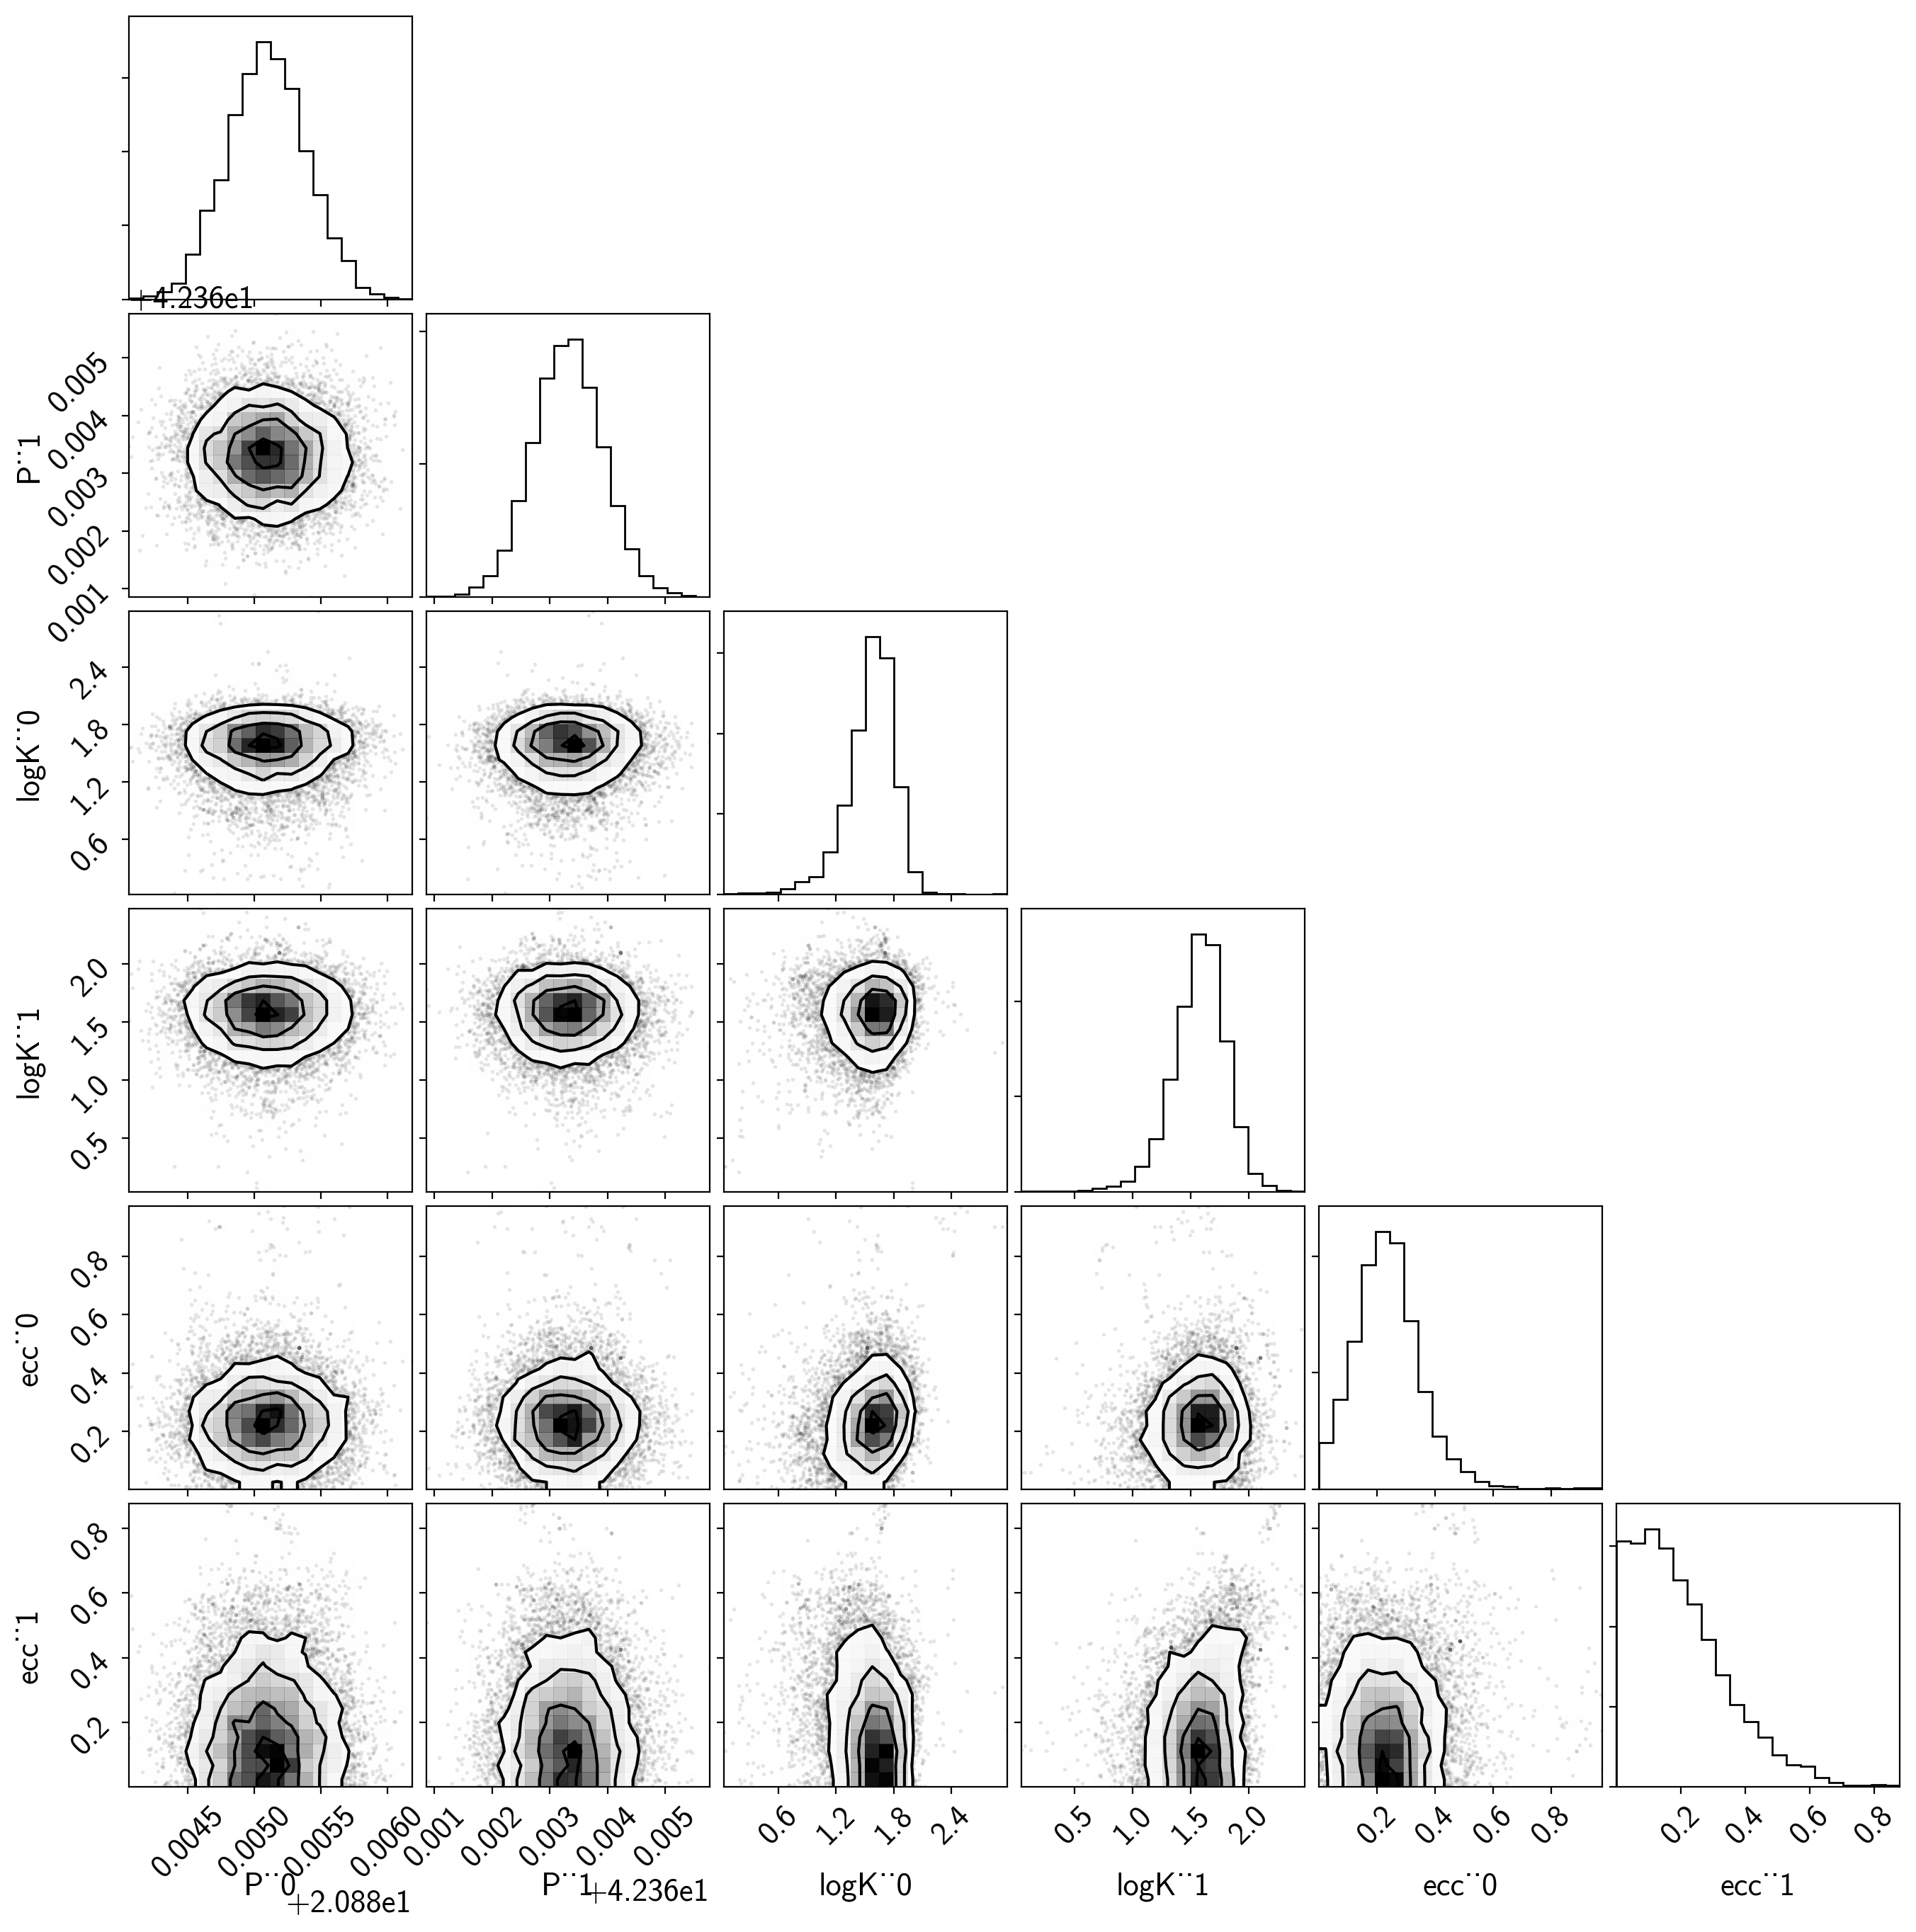

In [13]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=["P", "logK", "ecc"])
corner.corner(samples);

Finally, let's plot the plosterior constraints on the RV model and compare those to the data:

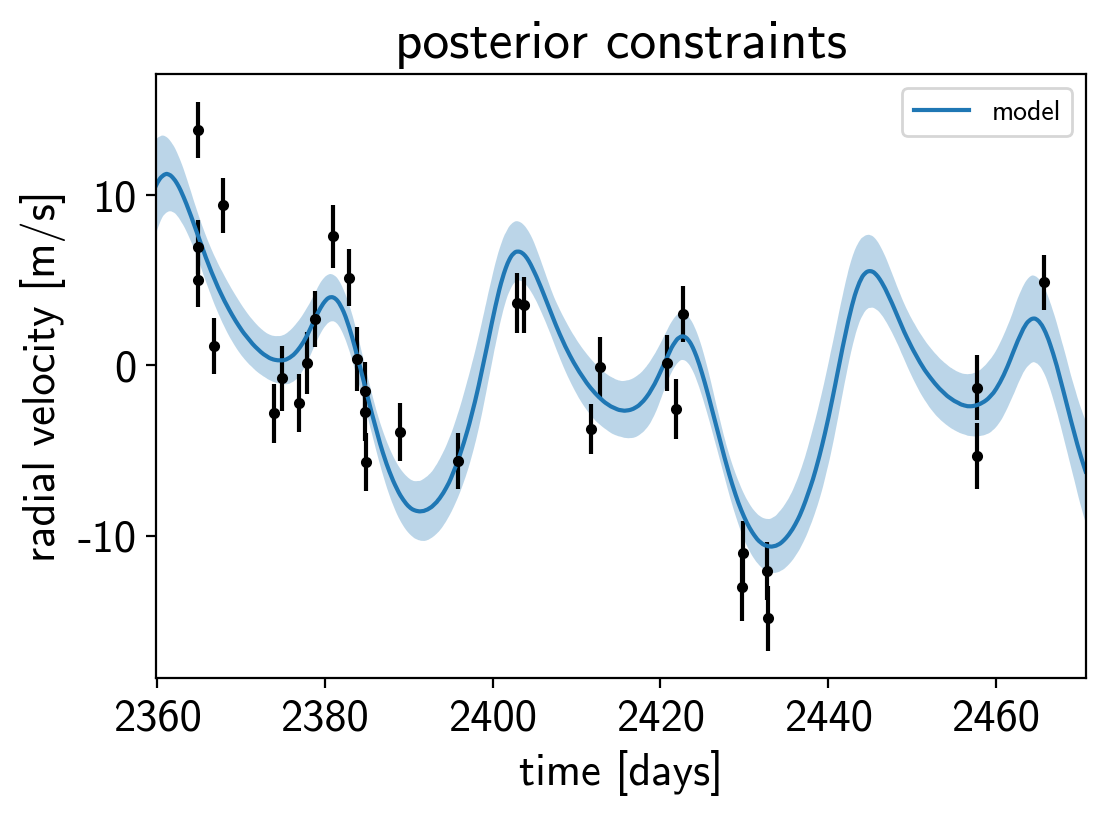

In [14]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

# Compute the posterior predictions for the RV model
pred = np.percentile(trace["rv_model_pred"], [16, 50, 84], axis=0)
plt.plot(t, pred[1], color="C0", label="model")
art = plt.fill_between(t, pred[0], pred[2], color="C0", alpha=0.3)
art.set_edgecolor("none")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
plt.title("posterior constraints");

## Phase plots

It might be also be interesting to look at the phased plots for this system.
Here we'll fold the dataset on the median of posterior period and then overplot the posterior constraint on the folded model orbits.

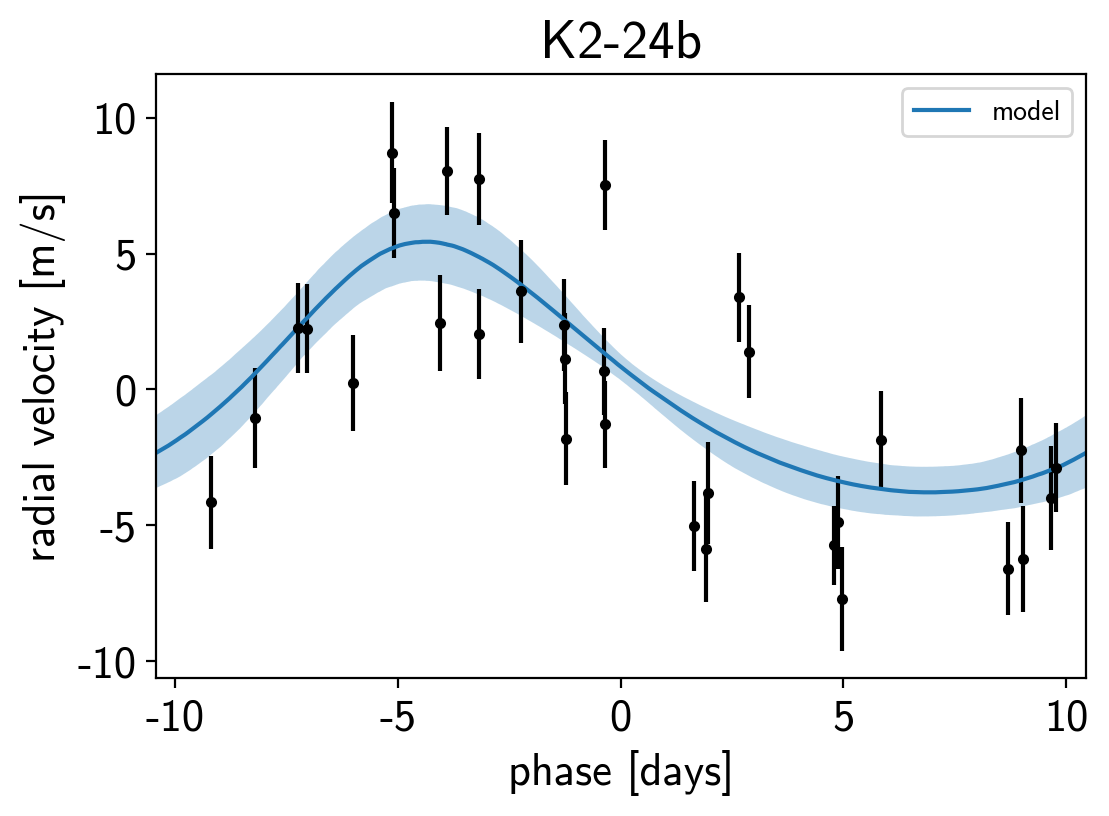

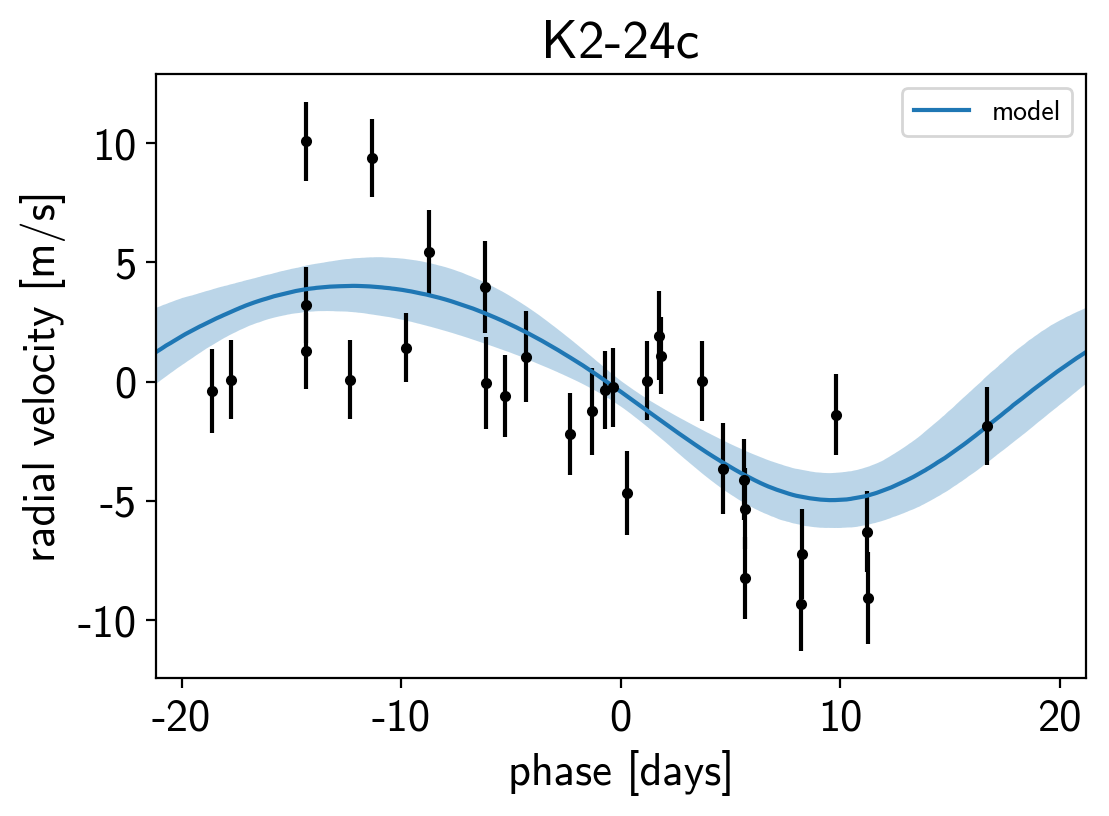

In [15]:
for n, letter in enumerate("bc"):    
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["P"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(trace["vrad"][:, :, (n + 1) % 2], axis=0)
    other += np.median(trace["bkg"], axis=0)

    # Plot the folded data
    x_fold = (x - t0 + 0.5*p) % p - 0.5*p
    plt.errorbar(x_fold, y - other, yerr=yerr, fmt=".k")
    
    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t - t0 + 0.5*p) % p - 0.5*p
    inds = np.argsort(t_fold)
    pred = np.percentile(trace["vrad_pred"][:, inds, n], [16, 50, 84], axis=0)
    plt.plot(t_fold[inds], pred[1], color="C0", label="model")
    art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C0", alpha=0.3)
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter));